In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
import sklearn
from sklearn.cluster import AgglomerativeClustering
from IPython.core.display import display

import time

import urllib.request
from bs4 import BeautifulSoup
import pyjsparser

import re
from collections import defaultdict

import pathos

import networkx as nx

ModuleNotFoundError: No module named 'SPARQLWrapper'

In [2]:
def order(df, blockpair):
    # order contact pair IDs blockwise: (seg1,res1,rnm1,bb1)<->(seg2,res2,rnm2,bb2)
    # by successively ordering as seg1<seg2, if "seg1==seg2": res1<res2,
    #                                        if "seg1==seg2" and "res1==res2": rnm1<rnm2,...
    blockpair_01 = [ x for y in blockpair       for x in y ]
    blockpair_10 = [ x for y in blockpair[::-1] for x in y ]
    pairs = np.transpose(blockpair)
    cumboolmask = pd.Series(np.ones(len(df), dtype="bool"))
    for mypair in pairs:
        boolmask    = np.logical_and((df[mypair[0]]   >= df[mypair[1]]), cumboolmask)
        if not boolmask.any():
            break
        df.loc[boolmask, blockpair_01] = df.loc[boolmask, blockpair_10].values
        cumboolmask = np.logical_and((df[mypair[0]]  == df[mypair[1]]), cumboolmask)

In [3]:
df_eurovoc_count = pd.read_excel("output/df_eurovoc_count.xlsx")
display(df_eurovoc_count.head())
print(len(df_eurovoc_count))

ID                          ev   mID  \
0  c_715c08c0                 3D printing  3236   
1  c_433922a6             cloud computing  3236   
2        5520    computer assisted design  3236   
3        5705                  disc drive  3236   
4        5920  database management system  3236   

                                          mev  mmID  \
0  information technology and data processing    32   
1  information technology and data processing    32   
2  information technology and data processing    32   
3  information technology and data processing    32   
4  information technology and data processing    32   

                           mmev  count  
0  EDUCATION AND COMMUNICATIONS      0  
1  EDUCATION AND COMMUNICATIONS      0  
2  EDUCATION AND COMMUNICATIONS      0  
3  EDUCATION AND COMMUNICATIONS      5  
4  EDUCATION AND COMMUNICATIONS      7

7124


In [4]:
df_eurovoc = pd.read_excel("data/DOC_1/eurovoc_export_en.xlsx")

In [5]:
print(len(df_eurovoc["ID"].drop_duplicates().values))
print(len(df_eurovoc.query("RELATIONS != RELATIONS")["ID"].drop_duplicates()))
#df_eurovoc.query("RELATIONS != RELATIONS").drop_duplicates()

7124
7124


In [7]:
df_eurovoc_doc = pd.DataFrame(columns = ["ID", "ev", "doc"])
starttime = time.time()
for i, key in enumerate(df_eurovoc["ID"].drop_duplicates()):
    if i % 100 == 0:
        print(i)
    sparql = SPARQLWrapper("http://publications.europa.eu/webapi/rdf/sparql")
    sparql.setQuery("""
prefix cdm: <http://publications.europa.eu/ontology/cdm#> 
select distinct?work
where
{
?work cdm:resource_legal_in-force "true"^^<http://www.w3.org/2001/XMLSchema#boolean> ;
a cdm:legislation_secondary;
cdm:work_is_about_concept_eurovoc <http://eurovoc.europa.eu/%s> .
}
    """ % key)
    sparql.setReturnFormat(JSON)

    querydone = False
    while not querydone:
        try:
            results = sparql.query().convert()
            querydone = True
        #except ConnectionResetError:
        #    print("%s caught ConnectionResetError" % (key))
        #    time.sleep(1)
        #except HTTPError:
        #    print("%s caught HTTPError" % (key))
        #    time.sleep(1)
        except Exception as e:
            print( "%s, caught Error: %s" % (key, str(e)) )
            time.sleep(1)
            
    df_eurovoc_doc.loc[i] = [key,
                               df_eurovoc.query("ID == '%s' and RELATIONS != RELATIONS" % key)["TERMS (PT-NPT)"].values[0],
                               [myentry["work"]["value"].split("cellar/")[-1] for myentry in results["results"]["bindings"]]]
endtime = time.time()
print(endtime - starttime)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
1806 caught ConnectionResetError
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
629.8583011627197


In [ ]:
df_tmp         = df_eurovoc_doc["doc"].apply(lambda x : pd.Series(x), 1)
df_tmp         = df_tmp.stack().to_frame()
df_tmp.index   = df_tmp.index.droplevel(1)
df_tmp.columns = ["cellar"]
df_eurovoc_doc = df_tmp.merge(df_eurovoc_doc[["ID", "ev"]], left_index = True, right_index = True)

In [ ]:
df_eurovoc_doc

In [ ]:
#df_eurovoc_doc.rename(columns={ "eurovoc" : "ev"}, inplace = True)
#df_eurovoc_doc = df_eurovoc_doc[["cellar", "ID", "ev"]]

In [ ]:
df_eurovoc_doc.query("cellar == 'f3931f63-15d2-11e7-808e-01aa75ed71a1'")

In [ ]:
df_eurovoc_doc.to_excel("output/df_eurovoc_doc.xlsx")
df_eurovoc_doc.to_hdf("output/df_eurovoc_doc.h5", key = "df_eurovoc_doc")

In [ ]:
df_eurovoc_doc.dtypes

In [6]:
#df_eurovoc_doc = pd.read_excel("output/df_eurovoc_doc.xlsx")
df_eurovoc_doc = pd.read_hdf("output/df_eurovoc_doc.h5")
#df_eurovoc_doc_new["ID"] = df_eurovoc_doc_new["ID"].astype("object")
#df_eurovoc_doc.rename(columns = { "eurovoc" : "ev"}, inplace = True)
df_eurovoc_doc

cellar      ID                  ev
1     f3931f63-15d2-11e7-808e-01aa75ed71a1  434966  emission allowance
1     e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966  emission allowance
1     0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966  emission allowance
1     005ef2ea-cac4-11e3-9fe4-01aa75ed71a1  434966  emission allowance
1     ae0737c9-4940-11e3-ae03-01aa75ed71a1  434966  emission allowance
1     ac6f6657-12e6-11e8-9253-01aa75ed71a1  434966  emission allowance
1     60227071-bf87-11e8-99ee-01aa75ed71a1  434966  emission allowance
1     39890cc2-dadd-11e7-a506-01aa75ed71a1  434966  emission allowance
1     c4180399-0430-11e9-adde-01aa75ed71a1  434966  emission allowance
3     ed341e6f-5d31-44fc-94e4-abd49cd2499d    2894     activity report
3     55a01a0c-747c-11e4-b593-01aa75ed71a1    2894     activity report
3     dfee6712-493a-11e2-8762-01aa75ed71a1    2894     activity report
3     e3764352-a1dd-42d3-bb52-e7105c6cdd00    2894     activity report
3     38be3625-08a0-4276-a2c6-1865b2aeca94    2894     activity report
3     4323a3b9-e3aa-4c3f-bb43-9391a2631867    2894     activity report
3     99d508ea-7886-453a-91b8-4bedefe6daeb    2894     activity report
3     429657a4-9b98-11e3-aa74-01aa75ed71a1    2894     activity report
3     b1784c93-e92d-43b2-8766-b2d21b2838fc    2894     activity report
3     412c1313-e4ea-454e-aec6-3688ad6b2263    2894     activity report
3     f00eda71-75ae-49b3-a896-e40fb55431ba    2894     activity report
3     c3784115-4182-11e5-9f5a-01aa75ed71a1    2894     activity report
3     19f5fb80-8714-4f77-b8f7-9eb6678e0150    2894     activity report
3     17270751-10ca-11e5-8817-01aa75ed71a1    2894     activity report
3     406ad3b8-6c9f-11e4-9680-01aa75ed71a1    2894     activity report
3     b3564e26-61bc-4661-a235-67145d787a36    2894     activity report
3     660373ca-7a84-11e2-9294-01aa75ed71a1    2894     activity report
3     0ded4f69-109c-40ef-b4ea-2b618cd3e4d5    2894     activity report
3     aaeadd2e-f84e-4d0b-88cf-e3e347126b06    2894     activity report
3     f1f8d23e-40fe-4c42-b9b8-f861c97bc05b    2894     activity report
3     b907e39d-0448-40a0-a974-c15babca644d    2894     activity report
...                                    ...     ...                 ...
7120  ec6c8b30-3410-448d-a7c0-52db451d1eb7    6322         zootechnics
7120  9dc5a64e-6e58-4936-8ce7-4c531bb36ea5    6322         zootechnics
7120  170482e1-5311-443b-91eb-ab3c9ce46ca5    6322         zootechnics
7120  c53bf7f6-8ad7-4e8b-a981-4c6e96acae30    6322         zootechnics
7120  dc9bfb76-013b-4f6e-b1bf-08d649677d92    6322         zootechnics
7120  51633f04-fb09-441a-9cfe-8236da1fcdf4    6322         zootechnics
7120  ba636ec1-79a6-11e7-b2f2-01aa75ed71a1    6322         zootechnics
7120  c786e690-6590-44c0-ba7f-d9a692e816fd    6322         zootechnics
7120  213e7a66-3dbb-11e6-a825-01aa75ed71a1    6322         zootechnics
7120  7757d87b-2a08-11e7-ab65-01aa75ed71a1    6322         zootechnics
7120  9e98032c-706b-46d0-9968-2abc3c1a0b3d    6322         zootechnics
7120  df56950d-8b87-42f3-b599-37771f2a2f0a    6322         zootechnics
7120  f0d56a00-d4d4-469d-ad82-cfb02c87c379    6322         zootechnics
7120  d00b1cc4-4bd3-4bb5-9b81-54f978feebec    6322         zootechnics
7120  d88297c5-8c12-444c-90c9-a99c5fbe8100    6322         zootechnics
7120  40e12141-1ba7-4110-84c8-93aae5a16c29    6322         zootechnics
7120  771ecd86-49b6-4386-ad5f-71956201ac49    6322         zootechnics
7120  57d8bdf7-53a2-4880-9f6c-0d4f748034c7    6322         zootechnics
7120  f3fe82b8-c47f-4f57-9fa7-4339185e249a    6322         zootechnics
7120  be8a4ff3-6c45-4878-adbf-1b9776b0ca5f    6322         zootechnics
7120  c969c22d-cb4b-477a-8cb2-6e1aad0ad9b5    6322         zootechnics
7120  9685f39e-66f9-4d38-85f4-bf60863b001f    6322         zootechnics
7120  a3572759-b519-4d77-9cc9-926c36cd8c8e    6322         zootechnics
7120  7cbbc9d2-e28d-443e-8f9a-9d5db99b4d59    6322         zootechnics
7120  93cf3970-3e32-4fe6-af58-2d074a456688    6322         z

In [7]:
df_eurovoc_doc = df_eurovoc_doc.merge(df_eurovoc_count.drop("count", axis = 1))
display(df_eurovoc_doc.head())
print(len(df_eurovoc_doc["ID"].unique()))

cellar      ID                  ev   mID  \
0  f3931f63-15d2-11e7-808e-01aa75ed71a1  434966  emission allowance  5206   
1  e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966  emission allowance  5206   
2  0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966  emission allowance  5206   
3  005ef2ea-cac4-11e3-9fe4-01aa75ed71a1  434966  emission allowance  5206   
4  ae0737c9-4940-11e3-ae03-01aa75ed71a1  434966  emission allowance  5206   

                    mev  mmID         mmev  
0  environmental policy    52  ENVIRONMENT  
1  environmental policy    52  ENVIRONMENT  
2  environmental policy    52  ENVIRONMENT  
3  environmental policy    52  ENVIRONMENT  
4  environmental policy    52  ENVIRONMENT

4842


In [8]:
df_eurovoc_doc.query("ID == '434966'")

cellar      ID                  ev   mID  \
0  f3931f63-15d2-11e7-808e-01aa75ed71a1  434966  emission allowance  5206   
1  e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966  emission allowance  5206   
2  0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966  emission allowance  5206   
3  005ef2ea-cac4-11e3-9fe4-01aa75ed71a1  434966  emission allowance  5206   
4  ae0737c9-4940-11e3-ae03-01aa75ed71a1  434966  emission allowance  5206   
5  ac6f6657-12e6-11e8-9253-01aa75ed71a1  434966  emission allowance  5206   
6  60227071-bf87-11e8-99ee-01aa75ed71a1  434966  emission allowance  5206   
7  39890cc2-dadd-11e7-a506-01aa75ed71a1  434966  emission allowance  5206   
8  c4180399-0430-11e9-adde-01aa75ed71a1  434966  emission allowance  5206   

                    mev  mmID         mmev  
0  environmental policy    52  ENVIRONMENT  
1  environmental policy    52  ENVIRONMENT  
2  environmental policy    52  ENVIRONMENT  
3  environmental policy    52  ENVIRONMENT  
4  environmental policy    52  ENVIRONMENT  
5  environmental policy    52  ENVIRONMENT  
6  environmental policy    52  ENVIRONMENT  
7  environmental policy    52  ENVIRONMENT  
8  environmental policy    52  ENVIRONMENT

In [9]:
df_eurovoc_doc.query("cellar == 'f3931f63-15d2-11e7-808e-01aa75ed71a1'")

cellar      ID                      ev  \
0       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966      emission allowance   
39073   f3931f63-15d2-11e7-808e-01aa75ed71a1    4195      investment company   
77941   f3931f63-15d2-11e7-808e-01aa75ed71a1    2098                    bond   
118511  f3931f63-15d2-11e7-808e-01aa75ed71a1    1459    financial instrument   
118747  f3931f63-15d2-11e7-808e-01aa75ed71a1     560   financial legislation   
119466  f3931f63-15d2-11e7-808e-01aa75ed71a1    4491   financial transaction   
134878  f3931f63-15d2-11e7-808e-01aa75ed71a1     248  stock-exchange listing   
172824  f3931f63-15d2-11e7-808e-01aa75ed71a1    5235      technical standard   

         mID                                   mev  mmID  \
0       5206                  environmental policy    52   
39073   2416     financial institutions and credit    24   
77941   2421              free movement of capital    24   
118511  2421              free movement of capital    24   
118747  2421              free movement of capital    24   
119466  2421              free movement of capital    24   
134878  2421              free movement of capital    24   
172824  6411  technology and technical regulations    64   

                                       mmev  
0                               ENVIRONMENT  
39073                               FINANCE  
77941                               FINANCE  
118511                              FINANCE  
118747                              FINANCE  
119466                              FINANCE  
134878                              FINANCE  
172824  PRODUCTION, TECHNOLOGY AND RESEARCH

In [10]:
df_eurovoc_doc

cellar      ID                  ev  \
0       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966  emission allowance   
1       e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966  emission allowance   
2       0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966  emission allowance   
3       005ef2ea-cac4-11e3-9fe4-01aa75ed71a1  434966  emission allowance   
4       ae0737c9-4940-11e3-ae03-01aa75ed71a1  434966  emission allowance   
5       ac6f6657-12e6-11e8-9253-01aa75ed71a1  434966  emission allowance   
6       60227071-bf87-11e8-99ee-01aa75ed71a1  434966  emission allowance   
7       39890cc2-dadd-11e7-a506-01aa75ed71a1  434966  emission allowance   
8       c4180399-0430-11e9-adde-01aa75ed71a1  434966  emission allowance   
9       ed341e6f-5d31-44fc-94e4-abd49cd2499d    2894     activity report   
10      55a01a0c-747c-11e4-b593-01aa75ed71a1    2894     activity report   
11      dfee6712-493a-11e2-8762-01aa75ed71a1    2894     activity report   
12      e3764352-a1dd-42d3-bb52-e7105c6cdd00    2894     activity report   
13      38be3625-08a0-4276-a2c6-1865b2aeca94    2894     activity report   
14      4323a3b9-e3aa-4c3f-bb43-9391a2631867    2894     activity report   
15      99d508ea-7886-453a-91b8-4bedefe6daeb    2894     activity report   
16      429657a4-9b98-11e3-aa74-01aa75ed71a1    2894     activity report   
17      b1784c93-e92d-43b2-8766-b2d21b2838fc    2894     activity report   
18      412c1313-e4ea-454e-aec6-3688ad6b2263    2894     activity report   
19      f00eda71-75ae-49b3-a896-e40fb55431ba    2894     activity report   
20      c3784115-4182-11e5-9f5a-01aa75ed71a1    2894     activity report   
21      19f5fb80-8714-4f77-b8f7-9eb6678e0150    2894     activity report   
22      17270751-10ca-11e5-8817-01aa75ed71a1    2894     activity report   
23      406ad3b8-6c9f-11e4-9680-01aa75ed71a1    2894     activity report   
24      b3564e26-61bc-4661-a235-67145d787a36    2894     activity report   
25      660373ca-7a84-11e2-9294-01aa75ed71a1    2894     activity report   
26      0ded4f69-109c-40ef-b4ea-2b618cd3e4d5    2894     activity report   
27      aaeadd2e-f84e-4d0b-88cf-e3e347126b06    2894     activity report   
28      f1f8d23e-40fe-4c42-b9b8-f861c97bc05b    2894     activity report   
29      b907e39d-0448-40a0-a974-c15babca644d    2894     activity report   
...                                      ...     ...                 ...   
180035  ec6c8b30-3410-448d-a7c0-52db451d1eb7    6322         zootechnics   
180036  9dc5a64e-6e58-4936-8ce7-4c531bb36ea5    6322         zootechnics   
180037  170482e1-5311-443b-91eb-ab3c9ce46ca5    6322         zootechnics   
180038  c53bf7f6-8ad7-4e8b-a981-4c6e96acae30    6322         zootechnics   
180039  dc9bfb76-013b-4f6e-b1bf-08d649677d92    6322         zootechnics   
180040  51633f04-fb09-441a-9cfe-8236da1fcdf4    6322         zootechnics   
180041  ba636ec1-79a6-11e7-b2f2-01aa75ed71a1    6322         zootechnics   
180042  c786e690-6590-44c0-ba7f-d9a692e816fd    6322         zootechnics   
180043  213e7a66-3dbb-11e6-a825-01aa75ed71a1    6322         zootechnics   
180044  7757d87b-2a08-11e7-ab65-01aa75ed71a1    6322         zootechnics   
180045  9e98032c-706b-46d0-9968-2abc3c1a0b3d    6322         zootechnics   
180046  df56950d-8b87-42f3-b599-37771f2a2f0a    6322         zootechnics   
180047  f0d56a00-d4d4-469d-ad82-cfb02c87c379    6322         zootechnics   
180048  d00b1cc4-4bd3-4bb5-9b81-54f978feebec    6322         zootechnics   
180049  d88297c5-8c12-444c-90c9-a99c5fbe8100    6322         zootechnics   
180050  40e12141-1ba7-4110-84c8-93aae5a16c29    6322         zootechnics   
180051  771ecd86-49b6-4386-ad5f-71956201ac49    6322         zootechnics   
180052  57d8bdf7-53a2-4880-9f6c-0d4f748034c7    6322         zootechnics   
180053  f3fe82b8-c47f-4f57-9fa7-4339185e249a    6322         zootechnics   
180054  be8a4ff3-6c45-4878-adbf-1b9776b0ca5f    6322         zootechnics   
180055  c969c22d-cb4b-477a-8cb2-6e1aad0ad9b5    6322         zootechnics   
180056  96

In [11]:
df_cellar2content = {}

In [12]:
len(df_eurovoc_doc["cellar"].unique())

29932

In [13]:
starttime = time.time()
starttime

1560366493.2160969

In [14]:
urlpage = "https://eur-lex.europa.eu/legal-content/EN/ALL/?uri=cellar:ed9d6f50-568e-11e4-a0cb-01aa75ed71a1"
page = urllib.request.urlopen(urlpage)
soup = BeautifulSoup(page, 'html.parser')
myid ="PP1Contents"
results = soup.find_all('div', attrs={ "id" : myid })
#results
qwer = list(results[0].stripped_strings)[1]
qwer

'Commission Regulation (EU) No 1096/2014 of 15 October 2014 amending Annexes II, III and\xa0V to Regulation (EC) No 396/2005 of the European Parliament and of the Council as regards maximum residue levels for carbaryl, procymidone and profenofos in or on certain products Text with EEA relevance'

In [15]:
starttime = time.time()

def getALL(args):
    i, cellarID = args
    if (i % 100 == 0) and (i > 0):
        delta_time = time.time() - starttime
        print(i, delta_time, delta_time / i)
    if cellarID in ["6ce63691-06c1-11e6-b713-01aa75ed71a1"]:
        return "\t".join([str(x) for x in [i, cellarID] + 3*["nan"]])
    # specify the url
    urlpage = 'https://eur-lex.europa.eu/legal-content/EN/ALL/?uri=cellar:%s' % (cellarID)
    #print(urlpage)
    # query the website and return the html to the variable 'page'
    querydone = False
    while not querydone:
        try:
            page = urllib.request.urlopen(urlpage)
            querydone = True
        except Exception as e:
            print( "%d, caught Error: %s" % (i, str(e)) )
            time.sleep(1)
    # parse the html using beautiful soup and store in variable 'soup'
    soup = BeautifulSoup(page, 'html.parser')
    d = {}
    for myid in [ "PPMisc_Contents", "PPDates_Contents", "PP1Contents"]:
        results = soup.find_all('div', attrs={ "id" : myid })
        try:
            results = list(results[0].stripped_strings)
        except:
            print(i, cellarID, results)
            raise
        if myid != "PP1Contents":
            indices = [i for i, s in enumerate(results) if re.search(':$', s)]
            d[myid] = defaultdict(list)
            for mykey, myvalue in zip([results[i] for i in indices], ["".join(results[indices[i]+1:indices[i+1]]) for i in range(len(indices)-1)] + ["".join(results[indices[-1]+1:])]):
                d[myid][mykey].append(myvalue)
            d[myid] = dict(d[myid])
        else:
            d["englishTitle"] = results[1]
    try:
        l_result = [i,
                cellarID,
                d["englishTitle"],
                d["PPDates_Contents"].get('Date of document:', ["nan"])[0].split(";")[0], 
                d["PPMisc_Contents"].get('Form:', ["nan"])[0],
                d["PPMisc_Contents"].get('Author:', ["nan"])[0]]
    except:
        print("Caught Error at", i, cellarID)
        display(d)
        raise
    #print(" ".join([str(x) for x in l_result]))
    return "\t".join([str(x) for x in l_result])

l_columns = ["cellar", "Title_eng", "Document Date", "Form", "Author"]
l_df_eurovoc_doc_unq = df_eurovoc_doc["cellar"].unique()
max_workers = 50
with open("output/l_getALL.dat", "a") as fout:
    fout.write("%s\n" % ("\t".join(l_columns)))
    pool = pathos.pools.ProcessPool(max_workers)
    pool.restart(force=True)
    
    start_i = 0
    #start_i = 20250
    #start_i = 20550
    finish_i = len(l_df_eurovoc_doc_unq)
    #finish_i = start_i + 101
    
    for i in range(start_i, finish_i, max_workers):
    #for i, mycellar in enumerate(df_eurovoc_doc["cellar"].unique()[:300]):
        print(i)
        l_args = zip(range(i,i+max_workers), l_df_eurovoc_doc_unq[i:i+max_workers])
        l_result = pool.amap(getALL, l_args)
        counter_i = 0
        while not l_result.ready():
            time.sleep(0.4)
            #if (counter_i // 10 >= 1)  and (counter_i % 5 == 0):
            #    print(counter_i, 'Waiting for child processes')
            counter_i += 1
        #print(l_result)
        l_result = l_result.get()
        fout.write("\n".join(l_result) + "\n")
        #df_cellar2content["ALL"] = [[mycellar] +  ]
    pool.close()
    pool.join()

0
50
100 17.550955295562744 0.17550955295562745
100
150
200 27.555742025375366 0.13777871012687684
200
250
300 41.17319321632385 0.13724397738774619
300
350
400 48.78365731239319 0.12195914328098297
400
450
500 57.193272829055786 0.11438654565811157
500
550
600 64.81105899810791 0.10801843166351319
600
650
700 81.62542819976807 0.11660775457109723
700
750
800 94.44091987609863 0.11805114984512328
800
850
900 114.46768760681152 0.12718631956312393
900
950
1000 123.27455639839172 0.12327455639839173
1000
1050
1100 140.0960021018982 0.12736000191081653
1100
1150
1200 153.31023836135864 0.12775853196779888
1200
1250
1300 162.5204906463623 0.1250157620356633
1300
1350
1400 177.73597049713135 0.1269542646408081
1400
1450
1500 184.1436185836792 0.12276241238911946
1500
1550
1600 190.95322179794312 0.11934576362371445
1600
1650
1700 198.56071496009827 0.11680042056476368
1700
1750
1800 204.96824169158936 0.11387124538421631
1800
1850
1900 211.777907371521 0.11146205651132685
1900
1950
2000 220

In [16]:
df_cellar2content["ALL"] = pd.read_csv("output/df_getALL.dat", 
                                       sep = "\t")
df_cellar2content["ALL"]

cellar  \
0      f3931f63-15d2-11e7-808e-01aa75ed71a1   
1      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1   
2      0053cbe4-8290-11e3-9b7d-01aa75ed71a1   
3      005ef2ea-cac4-11e3-9fe4-01aa75ed71a1   
4      ae0737c9-4940-11e3-ae03-01aa75ed71a1   
5      ac6f6657-12e6-11e8-9253-01aa75ed71a1   
6      60227071-bf87-11e8-99ee-01aa75ed71a1   
7      39890cc2-dadd-11e7-a506-01aa75ed71a1   
8      c4180399-0430-11e9-adde-01aa75ed71a1   
9      ed341e6f-5d31-44fc-94e4-abd49cd2499d   
10     55a01a0c-747c-11e4-b593-01aa75ed71a1   
11     dfee6712-493a-11e2-8762-01aa75ed71a1   
12     e3764352-a1dd-42d3-bb52-e7105c6cdd00   
13     38be3625-08a0-4276-a2c6-1865b2aeca94   
14     4323a3b9-e3aa-4c3f-bb43-9391a2631867   
15     99d508ea-7886-453a-91b8-4bedefe6daeb   
16     429657a4-9b98-11e3-aa74-01aa75ed71a1   
17     b1784c93-e92d-43b2-8766-b2d21b2838fc   
18     412c1313-e4ea-454e-aec6-3688ad6b2263   
19     f00eda71-75ae-49b3-a896-e40fb55431ba   
20     c3784115-4182-11e5-9f5a-01aa75ed71a1   
21     19f5fb80-8714-4f77-b8f7-9eb6678e0150   
22     17270751-10ca-11e5-8817-01aa75ed71a1   
23     406ad3b8-6c9f-11e4-9680-01aa75ed71a1   
24     b3564e26-61bc-4661-a235-67145d787a36   
25     660373ca-7a84-11e2-9294-01aa75ed71a1   
26     0ded4f69-109c-40ef-b4ea-2b618cd3e4d5   
27     aaeadd2e-f84e-4d0b-88cf-e3e347126b06   
28     f1f8d23e-40fe-4c42-b9b8-f861c97bc05b   
29     b907e39d-0448-40a0-a974-c15babca644d   
...                                     ...   
29902  f0d37574-7f54-4dfc-8f7b-b33187761255   
29903  94ec3c01-1b8d-4419-983f-bb8d46b18f8f   
29904  782edccc-28c2-4f19-a7c1-fa7b8fe9f1d1   
29905  d4c183be-2dcc-459b-988e-790bf5f0120a   
29906  be762c95-81ca-11e4-89f7-01aa75ed71a1   
29907  aa112a7b-2ec7-11e6-b497-01aa75ed71a1   
29908  aecb06ee-d883-4923-9c1e-b12d58a5a515   
29909  c5fa87c2-15f0-4ffc-ab94-324d62bfb793   
29910  9068a926-6c68-4508-a4ff-cfee414e05d2   
29911  087ea8dd-df2e-4356-955a-b5266c147616   
29912  c274a092-4363-440f-8107-ad98f3b89f07   
29913  13a924ef-2c33-4f09-83dd-10f4f85848e4   
29914  2e54fc2a-0c1a-4214-946d-ddaa7c6d711c   
29915  d0bd8d62-0bd0-40a7-b131-68bbfe91b48f   
29916  5cdcd07d-9270-4742-82f3-943bfcf111b3   
29917  4610017c-0913-48d4-9e1c-2653f2f84377   
29918  2daa77b3-18e0-4a3c-acc7-2fba6c3db66d   
29919  cb6b5c5d-32bc-11e6-b497-01aa75ed71a1   
29920  47ef4bd7-5cce-11e3-914b-01aa75ed71a1   
29921  af26e64a-06ea-4d0d-82fc-ea10a30ff7b0   
29922  7c435406-04e9-4861-be6b-55faf30d338f   
29923  9e1c15a8-a78a-49f9-8162-a5a19abc41a0   
29924  096621a4-dcb2-4b27-bfe8-ba065ed74aa6   
29925  eba0dff1-76da-49dc-9720-87fe3dc2d9b9   
29926  1bbc4f25-e703-490c-90ed-e78ab8824020   
29927  8cb2dd4d-edbc-455a-84d1-9dea109c638f   
29928  c39db218-5762-4144-b3e3-25db533e2565   
29929  ae28bf38-cbac-4d39-a289-b915e6ded76c   
29930  47cd42b9-8a26-42bf-96e2-64af0bad7e81   
29931  ec382043-7490-4031-a126-f1ec17e40a28   

                                               Title_eng Document Date  \
0      Commission Delegated Regulation (EU) 2017/583 ...    14/07/2016   
1      Commission Regulation (EU) No 1143/2013 of 13 ...    13/11/2013   
2      2014/26/EU: Commission Decision of 17 January ...    17/01/2014   
3      2014/224/EU: Commission Implementing Decision ...    16/04/2014   
4      Commission Regulation (EU) No 1123/2013 of 8 N...    08/11/2013   
5      Council Decision (EU) 2018/219 of 23 January 2...    23/01/2018   
6      Council Decision (EU) 2018/1279 of 18 Septembe...    18/09/2018   
7      Council Decision (EU) 2017/2240 of 10 November...    10/11/2017   
8      Council Decision (EU) 2018/2027 of 29 November...    29/11/2018   
9      Special report of the Court of Auditors on job...    04/08/1982   
10     Commission Delegated Regulation (EU) No 1255/2...    17/07/2014   
11     Commission Implementing Regulation (EU) No 120...    14/12/2012   
12     2011/92/EU: Commission Decision of 10 February...    10/02/2011   
13     Activity report on the Centre for Information,...    26/05/1997   
14     2004/

In [21]:
def test_f(x):
    if len(x) > 1:
        return x.iloc[1]
    else:
        return x.iloc[0]
df_sub = df_cellar2content["ALL"].groupby("Form")["cellar"].agg(lambda x: len(x)).reset_index()
df_sub

Form  cellar
0                                                 Act       1
1   Acts adopted by bodies created by internationa...      44
2                                            Addendum       1
3                                              Budget       4
4                                     Common position      73
5                                       Communication      60
6                                         Conclusions      62
7                                   Consolidated text      13
8                              Corrigendum Regulation       1
9                                            Decision   13168
10                                  Decision Decision      19
11                               Decision Information       1
12                                        Declaration      18
13                                 Delegated decision      19
14                                Delegated directive      58
15                               Delegated regulation     597
16                                          Directive    1248
17                               Financial regulation       5
18                                 Framework decision      23
19                                 General guidelines       2
20                                          Guideline      43
21                              Implementing decision    1878
22                             Implementing directive      58
23                            Implementing regulation    4059
24                                        Information      21
25                                         Initiative      12
26                       Interinstitutional agreement       8
27                                 Internal agreement       4
28                            International agreement      11
29                                       Joint action      58
30                               Judicial information       1
31                                               List       3
32                        Memorandum of understanding       5
33                                             Notice       5
34                                     Notice Opinion       1
35                                            Opinion     414
36                                    Preparatory act       2
37                                          Programme       7
38          Proposal for a decision without addressee       1
39                                           Protocol       2
40                                   Provisional data       4
41                                     Recommendation     604
42                                         Regulation    6622
43                                             Report      21
44                                         Resolution     487
45                                 Rules of procedure      46
46              Rules of procedure Rules of procedure       1
47                                     Special report     128
48                                            Statute       5
49                  Supplementary and amending budget       2

In [17]:
starttime = time.time()

def getHIS(args):
    i, cellarID = args
    if (i % 100 == 0) and (i > 0):
        delta_time = time.time() - starttime
        print(i, delta_time, delta_time / i)
    if cellarID in ["6ce63691-06c1-11e6-b713-01aa75ed71a1",
                    "a9c8c6a4-94ec-44b2-b11d-39a25dd3d8eb",
                    "facfbd6b-9367-42c8-8523-2dde2039b437",
                    "374f7a20-1a55-4320-9087-a59ce247c2b4",
                    "19cbaba1-ccaf-42b4-8991-1f58f963985e",
                    "6e248d9e-bfc6-464d-81da-631868bd15ab",
                    "f76faa39-2b27-42f2-be1e-9332f795e324"]:
        return "\t".join([str(x) for x in [i, cellarID] + 3*["nan"]])
    # specify the url
    urlpage = 'https://eur-lex.europa.eu/legal-content/EN/HIS/?uri=cellar:%s' % (cellarID)
    #print(urlpage)
    # query the website and return the html to the variable 'page'
    querydone = False
    while not querydone:
        try:
            page = urllib.request.urlopen(urlpage)
            querydone = True
        except Exception as e:
            print( "%d, caught Error: %s" % (i, str(e)) )
            time.sleep(1)
    # parse the html using beautiful soup and store in variable 'soup'
    soup = BeautifulSoup(page, 'html.parser')
    results = soup.find_all('script', text=re.compile(r'titleJson'))
    #print(i, len(results))
    if len(results) == 0:
        return "\t".join([str(x) for x in [i, cellarID] + 3*["nan"]])
    try:
        results = pyjsparser.parse(results[0].contents[0])
    except:
        print("debug", cellarID, results[0].contents[0])
        raise
    
    var2path = {}
    var2path["title"]     = results["body"][0]['declarations'][0]['init']['properties'][0]
    var2path["startYear"] = results["body"][2]['declarations'][0]['init']['properties'][0]
    var2path["endYear"]   = results["body"][2]['declarations'][0]['init']['properties'][1]
    def key2value(x):
        assert var2path[mykey]['key']['value'] == x
        return var2path[mykey]['value']['value']
    d = {}
    for mykey, myval in var2path.items():
        d[mykey] = key2value(mykey)
    
    #l_result = [d["title"], d["startYear"], d["endYear"]]
    #return "\t".join([str(x) for x in [i, cellarID] + l_result])
    try:
        l_result = [i,
                cellarID,
                d.get("title", "nan"),
                d.get("startYear", "nan"),
                d.get("endYear", "nan")]
    except:
        print("Caught Error at", i, cellarID)
        display(d)
        raise
    return "\t".join([str(x) for x in l_result])

l_columns = ["cellar", "ProcTitle", "startYear", "endYear"]
l_df_eurovoc_doc_unq = df_eurovoc_doc["cellar"].unique()
max_workers = 50
with open("output/df_getHIS.dat", "a") as fout:
    #fout.write("%s\n" % ("\t".join(l_columns)))
    pool = pathos.pools.ProcessPool(max_workers)
    pool.restart(force=True)
    
    start_i = 0
    #start_i = 9700
    #start_i = 13600
    #start_i = 18150
    #start_i = 19750
    #start_i = 20700
    #start_i = 27000
    finish_i = len(l_df_eurovoc_doc_unq)
    #finish_i = start_i + 101
    
    for i in range(start_i, finish_i, max_workers):
    #for i, mycellar in enumerate(df_eurovoc_doc["cellar"].unique()[:300]):
        print(i)
        l_args = zip(range(i,i+max_workers), l_df_eurovoc_doc_unq[i:i+max_workers])
        l_result = pool.amap(getHIS, l_args)
        counter_i = 0
        while not l_result.ready():
            time.sleep(0.4)
            #if (counter_i // 10 >= 1) and (counter_i % 5 == 0):
            #    print(counter_i, 'Waiting for child processes')
            counter_i += 1
        l_result = l_result.get()
        fout.write("\n".join(l_result) + "\n")
        #df_cellar2content["ALL"] = [[mycellar] +  ]
    pool.close()
    pool.join()

0
50
100 10.284741401672363 0.10284741401672363
100
150
200 17.49076771736145 0.08745383858680725
200
250
300 28.70789670944214 0.0956929890314738
300
350
400 37.519458293914795 0.09379864573478698
400
450
500 51.136850118637085 0.10227370023727417
500
550
600 61.148032665252686 0.10191338777542114
600
650
700 71.9609146118164 0.10280130658830915
700
750
800 80.77094292640686 0.10096367865800858
800
850
900 88.7799904346466 0.09864443381627401
900
950
1000 99.19217324256897 0.09919217324256897
1000
1050
1100 108.40029215812683 0.09854572014375167
1100
1150
1200 118.01293349266052 0.09834411124388377
1200
1250
1300 124.01922345161438 0.09539940265508798
1300
1350
1400 136.0348174571991 0.09716772675514221
1400
1450
1500 144.44458150863647 0.09629638767242432
1500
1550
1600 152.45331597328186 0.09528332248330117
1600
1650
1700 160.06279253959656 0.0941545838468215
1700
1750
1800 168.47277283668518 0.09359598490926954
1800
1850
1900 174.88085675239563 0.09204255618547139
1900
1950
2000 19

In [17]:
df_cellar2content["HIS"] = pd.read_csv("output/df_getHIS.dat", 
                                       sep = "\t")
df_cellar2content["HIS"]

cellar                ProcTitle  \
0      f3931f63-15d2-11e7-808e-01aa75ed71a1                      NaN   
1      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1                      NaN   
2      0053cbe4-8290-11e3-9b7d-01aa75ed71a1                      NaN   
3      005ef2ea-cac4-11e3-9fe4-01aa75ed71a1                      NaN   
4      ae0737c9-4940-11e3-ae03-01aa75ed71a1                      NaN   
5      ac6f6657-12e6-11e8-9253-01aa75ed71a1  Procedure 2017/0193/NLE   
6      60227071-bf87-11e8-99ee-01aa75ed71a1  Procedure 2018/0192/NLE   
7      39890cc2-dadd-11e7-a506-01aa75ed71a1  Procedure 2017/0194/NLE   
8      c4180399-0430-11e9-adde-01aa75ed71a1  Procedure 2018/0372/NLE   
9      ed341e6f-5d31-44fc-94e4-abd49cd2499d                      NaN   
10     55a01a0c-747c-11e4-b593-01aa75ed71a1                      NaN   
11     dfee6712-493a-11e2-8762-01aa75ed71a1                      NaN   
12     e3764352-a1dd-42d3-bb52-e7105c6cdd00                      NaN   
13     38be3625-08a0-4276-a2c6-1865b2aeca94                      NaN   
14     4323a3b9-e3aa-4c3f-bb43-9391a2631867                      NaN   
15     99d508ea-7886-453a-91b8-4bedefe6daeb                      NaN   
16     429657a4-9b98-11e3-aa74-01aa75ed71a1                      NaN   
17     b1784c93-e92d-43b2-8766-b2d21b2838fc                      NaN   
18     412c1313-e4ea-454e-aec6-3688ad6b2263                      NaN   
19     f00eda71-75ae-49b3-a896-e40fb55431ba                      NaN   
20     c3784115-4182-11e5-9f5a-01aa75ed71a1                      NaN   
21     19f5fb80-8714-4f77-b8f7-9eb6678e0150                      NaN   
22     17270751-10ca-11e5-8817-01aa75ed71a1                      NaN   
23     406ad3b8-6c9f-11e4-9680-01aa75ed71a1  Procedure 2013/0110/COD   
24     b3564e26-61bc-4661-a235-67145d787a36                      NaN   
25     660373ca-7a84-11e2-9294-01aa75ed71a1                      NaN   
26     0ded4f69-109c-40ef-b4ea-2b618cd3e4d5                      NaN   
27     aaeadd2e-f84e-4d0b-88cf-e3e347126b06                      NaN   
28     f1f8d23e-40fe-4c42-b9b8-f861c97bc05b                      NaN   
29     b907e39d-0448-40a0-a974-c15babca644d                      NaN   
...                                     ...                      ...   
29902  f0d37574-7f54-4dfc-8f7b-b33187761255                      NaN   
29903  94ec3c01-1b8d-4419-983f-bb8d46b18f8f                      NaN   
29904  782edccc-28c2-4f19-a7c1-fa7b8fe9f1d1                      NaN   
29905  d4c183be-2dcc-459b-988e-790bf5f0120a  Procedure 2006/0272/COD   
29906  be762c95-81ca-11e4-89f7-01aa75ed71a1                      NaN   
29907  aa112a7b-2ec7-11e6-b497-01aa75ed71a1                      NaN   
29908  aecb06ee-d883-4923-9c1e-b12d58a5a515                      NaN   
29909  c5fa87c2-15f0-4ffc-ab94-324d62bfb793                      NaN   
29910  9068a926-6c68-4508-a4ff-cfee414e05d2                      NaN   
29911  087ea8dd-df2e-4356-955a-b5266c147616                      NaN   
29912  c274a092-4363-440f-8107-ad98f3b89f07                      NaN   
29913  13a924ef-2c33-4f09-83dd-10f4f85848e4                      NaN   
29914  2e54fc2a-0c1a-4214-946d-ddaa7c6d711c                      NaN   
29915  d0bd8d62-0bd0-40a7-b131-68bbfe91b48f                      NaN   
29916  5cdcd07d-9270-4742-82f3-943bfcf111b3                      NaN   
29917  4610017c-0913-48d4-9e1c-2653f2f84377               Procedure    
29918  2daa77b3-18e0-4a3c-acc7-2fba6c3db66d                      NaN   
29919  cb6b5c5d-32bc-11e6-b497-01aa75ed71a1                      NaN   
29920  47ef4bd7-5cce-11e3-914b-01aa75ed71a1                      NaN   
29921  af26e64a-06ea-4d0d-82fc-ea10a30ff7b0                      NaN   
29922  7c435406-04e9-4861-be6b-55faf30d338f                      NaN   
29923  9e1c15a8-a78a-49f9-8162-a5a19abc41a0                      NaN   
29924  096621a4-dcb2-4b27-bfe8-ba065ed74aa6                      NaN   
29925  eba0dff1-76da-49dc-9720-87fe3dc2d9b9                      NaN   
29926

In [18]:
df_cellar2content["merged"] = df_cellar2content["ALL"].merge(df_cellar2content["HIS"], how = "outer")
print(len(df_cellar2content["merged"]))
df_cellar2content["merged"]

59864


cellar  \
0      f3931f63-15d2-11e7-808e-01aa75ed71a1   
1      f3931f63-15d2-11e7-808e-01aa75ed71a1   
2      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1   
3      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1   
4      0053cbe4-8290-11e3-9b7d-01aa75ed71a1   
5      0053cbe4-8290-11e3-9b7d-01aa75ed71a1   
6      005ef2ea-cac4-11e3-9fe4-01aa75ed71a1   
7      005ef2ea-cac4-11e3-9fe4-01aa75ed71a1   
8      ae0737c9-4940-11e3-ae03-01aa75ed71a1   
9      ae0737c9-4940-11e3-ae03-01aa75ed71a1   
10     ac6f6657-12e6-11e8-9253-01aa75ed71a1   
11     ac6f6657-12e6-11e8-9253-01aa75ed71a1   
12     60227071-bf87-11e8-99ee-01aa75ed71a1   
13     60227071-bf87-11e8-99ee-01aa75ed71a1   
14     39890cc2-dadd-11e7-a506-01aa75ed71a1   
15     39890cc2-dadd-11e7-a506-01aa75ed71a1   
16     c4180399-0430-11e9-adde-01aa75ed71a1   
17     c4180399-0430-11e9-adde-01aa75ed71a1   
18     ed341e6f-5d31-44fc-94e4-abd49cd2499d   
19     ed341e6f-5d31-44fc-94e4-abd49cd2499d   
20     55a01a0c-747c-11e4-b593-01aa75ed71a1   
21     55a01a0c-747c-11e4-b593-01aa75ed71a1   
22     dfee6712-493a-11e2-8762-01aa75ed71a1   
23     dfee6712-493a-11e2-8762-01aa75ed71a1   
24     e3764352-a1dd-42d3-bb52-e7105c6cdd00   
25     e3764352-a1dd-42d3-bb52-e7105c6cdd00   
26     38be3625-08a0-4276-a2c6-1865b2aeca94   
27     38be3625-08a0-4276-a2c6-1865b2aeca94   
28     4323a3b9-e3aa-4c3f-bb43-9391a2631867   
29     4323a3b9-e3aa-4c3f-bb43-9391a2631867   
...                                     ...   
59834  4610017c-0913-48d4-9e1c-2653f2f84377   
59835  4610017c-0913-48d4-9e1c-2653f2f84377   
59836  2daa77b3-18e0-4a3c-acc7-2fba6c3db66d   
59837  2daa77b3-18e0-4a3c-acc7-2fba6c3db66d   
59838  cb6b5c5d-32bc-11e6-b497-01aa75ed71a1   
59839  cb6b5c5d-32bc-11e6-b497-01aa75ed71a1   
59840  47ef4bd7-5cce-11e3-914b-01aa75ed71a1   
59841  47ef4bd7-5cce-11e3-914b-01aa75ed71a1   
59842  af26e64a-06ea-4d0d-82fc-ea10a30ff7b0   
59843  af26e64a-06ea-4d0d-82fc-ea10a30ff7b0   
59844  7c435406-04e9-4861-be6b-55faf30d338f   
59845  7c435406-04e9-4861-be6b-55faf30d338f   
59846  9e1c15a8-a78a-49f9-8162-a5a19abc41a0   
59847  9e1c15a8-a78a-49f9-8162-a5a19abc41a0   
59848  096621a4-dcb2-4b27-bfe8-ba065ed74aa6   
59849  096621a4-dcb2-4b27-bfe8-ba065ed74aa6   
59850  eba0dff1-76da-49dc-9720-87fe3dc2d9b9   
59851  eba0dff1-76da-49dc-9720-87fe3dc2d9b9   
59852  1bbc4f25-e703-490c-90ed-e78ab8824020   
59853  1bbc4f25-e703-490c-90ed-e78ab8824020   
59854  8cb2dd4d-edbc-455a-84d1-9dea109c638f   
59855  8cb2dd4d-edbc-455a-84d1-9dea109c638f   
59856  c39db218-5762-4144-b3e3-25db533e2565   
59857  c39db218-5762-4144-b3e3-25db533e2565   
59858  ae28bf38-cbac-4d39-a289-b915e6ded76c   
59859  ae28bf38-cbac-4d39-a289-b915e6ded76c   
59860  47cd42b9-8a26-42bf-96e2-64af0bad7e81   
59861  47cd42b9-8a26-42bf-96e2-64af0bad7e81   
59862  ec382043-7490-4031-a126-f1ec17e40a28   
59863  ec382043-7490-4031-a126-f1ec17e40a28   

                                               Title_eng Document Date  \
0      Commission Delegated Regulation (EU) 2017/583 ...    14/07/2016   
1      Commission Delegated Regulation (EU) 2017/583 ...    14/07/2016   
2      Commission Regulation (EU) No 1143/2013 of 13 ...    13/11/2013   
3      Commission Regulation (EU) No 1143/2013 of 13 ...    13/11/2013   
4      2014/26/EU: Commission Decision of 17 January ...    17/01/2014   
5      2014/26/EU: Commission Decision of 17 January ...    17/01/2014   
6      2014/224/EU: Commission Implementing Decision ...    16/04/2014   
7      2014/224/EU: Commission Implementing Decision ...    16/04/2014   
8      Commission Regulation (EU) No 1123/2013 of 8 N...    08/11/2013   
9      Commission Regulation (EU) No 1123/2013 of 8 N...    08/11/2013   
10     Council Decision (EU) 2018/219 of 23 January 2...    23/01/2018   
11     Council Decision (EU) 2018/219 of 23 January 2...    23/01/2018   
12     Council Decision (EU) 2018/1279 of 18 Septembe...    18/09/2018   
13     Council Decision (EU) 2018/1279 of 18 Septembe...    18/09/2018   
14     Counc

In [19]:
print(len(df_eurovoc_doc))
print(len(df_eurovoc_doc["cellar"].unique()))
df_eurovoc_doc

180065
29932


cellar      ID                  ev  \
0       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966  emission allowance   
1       e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966  emission allowance   
2       0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966  emission allowance   
3       005ef2ea-cac4-11e3-9fe4-01aa75ed71a1  434966  emission allowance   
4       ae0737c9-4940-11e3-ae03-01aa75ed71a1  434966  emission allowance   
5       ac6f6657-12e6-11e8-9253-01aa75ed71a1  434966  emission allowance   
6       60227071-bf87-11e8-99ee-01aa75ed71a1  434966  emission allowance   
7       39890cc2-dadd-11e7-a506-01aa75ed71a1  434966  emission allowance   
8       c4180399-0430-11e9-adde-01aa75ed71a1  434966  emission allowance   
9       ed341e6f-5d31-44fc-94e4-abd49cd2499d    2894     activity report   
10      55a01a0c-747c-11e4-b593-01aa75ed71a1    2894     activity report   
11      dfee6712-493a-11e2-8762-01aa75ed71a1    2894     activity report   
12      e3764352-a1dd-42d3-bb52-e7105c6cdd00    2894     activity report   
13      38be3625-08a0-4276-a2c6-1865b2aeca94    2894     activity report   
14      4323a3b9-e3aa-4c3f-bb43-9391a2631867    2894     activity report   
15      99d508ea-7886-453a-91b8-4bedefe6daeb    2894     activity report   
16      429657a4-9b98-11e3-aa74-01aa75ed71a1    2894     activity report   
17      b1784c93-e92d-43b2-8766-b2d21b2838fc    2894     activity report   
18      412c1313-e4ea-454e-aec6-3688ad6b2263    2894     activity report   
19      f00eda71-75ae-49b3-a896-e40fb55431ba    2894     activity report   
20      c3784115-4182-11e5-9f5a-01aa75ed71a1    2894     activity report   
21      19f5fb80-8714-4f77-b8f7-9eb6678e0150    2894     activity report   
22      17270751-10ca-11e5-8817-01aa75ed71a1    2894     activity report   
23      406ad3b8-6c9f-11e4-9680-01aa75ed71a1    2894     activity report   
24      b3564e26-61bc-4661-a235-67145d787a36    2894     activity report   
25      660373ca-7a84-11e2-9294-01aa75ed71a1    2894     activity report   
26      0ded4f69-109c-40ef-b4ea-2b618cd3e4d5    2894     activity report   
27      aaeadd2e-f84e-4d0b-88cf-e3e347126b06    2894     activity report   
28      f1f8d23e-40fe-4c42-b9b8-f861c97bc05b    2894     activity report   
29      b907e39d-0448-40a0-a974-c15babca644d    2894     activity report   
...                                      ...     ...                 ...   
180035  ec6c8b30-3410-448d-a7c0-52db451d1eb7    6322         zootechnics   
180036  9dc5a64e-6e58-4936-8ce7-4c531bb36ea5    6322         zootechnics   
180037  170482e1-5311-443b-91eb-ab3c9ce46ca5    6322         zootechnics   
180038  c53bf7f6-8ad7-4e8b-a981-4c6e96acae30    6322         zootechnics   
180039  dc9bfb76-013b-4f6e-b1bf-08d649677d92    6322         zootechnics   
180040  51633f04-fb09-441a-9cfe-8236da1fcdf4    6322         zootechnics   
180041  ba636ec1-79a6-11e7-b2f2-01aa75ed71a1    6322         zootechnics   
180042  c786e690-6590-44c0-ba7f-d9a692e816fd    6322         zootechnics   
180043  213e7a66-3dbb-11e6-a825-01aa75ed71a1    6322         zootechnics   
180044  7757d87b-2a08-11e7-ab65-01aa75ed71a1    6322         zootechnics   
180045  9e98032c-706b-46d0-9968-2abc3c1a0b3d    6322         zootechnics   
180046  df56950d-8b87-42f3-b599-37771f2a2f0a    6322         zootechnics   
180047  f0d56a00-d4d4-469d-ad82-cfb02c87c379    6322         zootechnics   
180048  d00b1cc4-4bd3-4bb5-9b81-54f978feebec    6322         zootechnics   
180049  d88297c5-8c12-444c-90c9-a99c5fbe8100    6322         zootechnics   
180050  40e12141-1ba7-4110-84c8-93aae5a16c29    6322         zootechnics   
180051  771ecd86-49b6-4386-ad5f-71956201ac49    6322         zootechnics   
180052  57d8bdf7-53a2-4880-9f6c-0d4f748034c7    6322         zootechnics   
180053  f3fe82b8-c47f-4f57-9fa7-4339185e249a    6322         zootechnics   
180054  be8a4ff3-6c45-4878-adbf-1b9776b0ca5f    6322         zootechnics   
180055  c969c22d-cb4b-477a-8cb2-6e1aad0ad9b5    6322         zootechnics   
180056  96

In [20]:
df_eurovoc_doc_full = df_eurovoc_doc.merge(df_cellar2content["merged"], how = "outer")
print(len(df_eurovoc_doc_full))
df_eurovoc_doc_full.to_excel("output/df_eurovoc_doc_full.xlsx")
df_eurovoc_doc_full.to_csv("output/df_eurovoc_doc_full.tsv", sep = "\t", index = False)

360130


In [29]:
df_eurovoc_doc_full.to_csv("output/df_eurovoc_doc_full.tsv", sep = "\t", index = False)

In [21]:
df_eurovoc_doc_full.to_hdf("output/df_eurovoc_doc_full.h5",
                           key = "df_eurovoc_doc_full",
                           index = False)

/home/mi/sstolzen/mystore/mypackages/miniconda3/envs/python34/lib/python3.4/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['cellar', 'ID', 'ev', 'mev', 'mmev', 'Title_eng', 'Document Date', 'Form', 'Author', 'ProcTitle']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [22]:
df_eurovoc_doc_full

cellar      ID  \
0       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966   
1       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966   
2       f3931f63-15d2-11e7-808e-01aa75ed71a1    4195   
3       f3931f63-15d2-11e7-808e-01aa75ed71a1    4195   
4       f3931f63-15d2-11e7-808e-01aa75ed71a1    2098   
5       f3931f63-15d2-11e7-808e-01aa75ed71a1    2098   
6       f3931f63-15d2-11e7-808e-01aa75ed71a1    1459   
7       f3931f63-15d2-11e7-808e-01aa75ed71a1    1459   
8       f3931f63-15d2-11e7-808e-01aa75ed71a1     560   
9       f3931f63-15d2-11e7-808e-01aa75ed71a1     560   
10      f3931f63-15d2-11e7-808e-01aa75ed71a1    4491   
11      f3931f63-15d2-11e7-808e-01aa75ed71a1    4491   
12      f3931f63-15d2-11e7-808e-01aa75ed71a1     248   
13      f3931f63-15d2-11e7-808e-01aa75ed71a1     248   
14      f3931f63-15d2-11e7-808e-01aa75ed71a1    5235   
15      f3931f63-15d2-11e7-808e-01aa75ed71a1    5235   
16      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966   
17      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966   
18      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434880   
19      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434880   
20      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    1318   
21      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    1318   
22      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434004   
23      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434004   
24      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    4668   
25      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    4668   
26      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    5650   
27      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    5650   
28      0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966   
29      0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966   
...                                      ...     ...   
360100  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4316   
360101  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4316   
360102  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4315   
360103  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4315   
360104  096621a4-dcb2-4b27-bfe8-ba065ed74aa6     276   
360105  096621a4-dcb2-4b27-bfe8-ba065ed74aa6     276   
360106  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4316   
360107  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4316   
360108  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4315   
360109  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4315   
360110  eba0dff1-76da-49dc-9720-87fe3dc2d9b9     276   
360111  eba0dff1-76da-49dc-9720-87fe3dc2d9b9     276   
360112  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4170   
360113  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4170   
360114  1bbc4f25-e703-490c-90ed-e78ab8824020     431   
360115  1bbc4f25-e703-490c-90ed-e78ab8824020     431   
360116  1bbc4f25-e703-490c-90ed-e78ab8824020      86   
360117  1bbc4f25-e703-490c-90ed-e78ab8824020      86   
360118  8cb2dd4d-edbc-455a-84d1-9dea109c638f     431   
360119  8cb2dd4d-edbc-455a-84d1-9dea109c638f     431   
360120  8cb2dd4d-edbc-455a-84d1-9dea109c638f    1184   
360121  8cb2dd4d-edbc-455a-84d1-9dea109c638f    1184   
360122  c39db218-5762-4144-b3e3-25db533e2565     431   
360123  c39db218-5762-4144-b3e3-25db533e2565     431   
360124  ae28bf38-cbac-4d39-a289-b915e6ded76c    5872   
360125  ae28bf38-cbac-4d39-a289-b915e6ded76c    5872   
360126  47cd42b9-8a26-42bf-96e2-64af0bad7e81    1433   
360127  47cd42b9-8a26-42bf-96e2-64af0bad7e81    1433   
360128  ec382043-7490-4031-a126-f1ec17e40a28    1433   
360129  ec382043-7490-4031-a126-f1ec17e40a28    1433   

                                        ev   mID  \
0                       emission allowance  5206   
1                       emission allowance  5206   
2                       investment company  2416   
3                       investment company  2416   
4                                     bond  2421   
5                                     bond  2421   
6                     financial instrument  2421   
7                     financial instrument  2421   
8                    financial legislation  2421   
9                    financial legislation  2

In [23]:
df_abc = pd.read_hdf("output/df_eurovoc_doc_full.h5")
df_abc

cellar      ID  \
0       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966   
1       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966   
2       f3931f63-15d2-11e7-808e-01aa75ed71a1    4195   
3       f3931f63-15d2-11e7-808e-01aa75ed71a1    4195   
4       f3931f63-15d2-11e7-808e-01aa75ed71a1    2098   
5       f3931f63-15d2-11e7-808e-01aa75ed71a1    2098   
6       f3931f63-15d2-11e7-808e-01aa75ed71a1    1459   
7       f3931f63-15d2-11e7-808e-01aa75ed71a1    1459   
8       f3931f63-15d2-11e7-808e-01aa75ed71a1     560   
9       f3931f63-15d2-11e7-808e-01aa75ed71a1     560   
10      f3931f63-15d2-11e7-808e-01aa75ed71a1    4491   
11      f3931f63-15d2-11e7-808e-01aa75ed71a1    4491   
12      f3931f63-15d2-11e7-808e-01aa75ed71a1     248   
13      f3931f63-15d2-11e7-808e-01aa75ed71a1     248   
14      f3931f63-15d2-11e7-808e-01aa75ed71a1    5235   
15      f3931f63-15d2-11e7-808e-01aa75ed71a1    5235   
16      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966   
17      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966   
18      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434880   
19      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434880   
20      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    1318   
21      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    1318   
22      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434004   
23      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434004   
24      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    4668   
25      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    4668   
26      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    5650   
27      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    5650   
28      0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966   
29      0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966   
...                                      ...     ...   
360100  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4316   
360101  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4316   
360102  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4315   
360103  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4315   
360104  096621a4-dcb2-4b27-bfe8-ba065ed74aa6     276   
360105  096621a4-dcb2-4b27-bfe8-ba065ed74aa6     276   
360106  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4316   
360107  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4316   
360108  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4315   
360109  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4315   
360110  eba0dff1-76da-49dc-9720-87fe3dc2d9b9     276   
360111  eba0dff1-76da-49dc-9720-87fe3dc2d9b9     276   
360112  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4170   
360113  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4170   
360114  1bbc4f25-e703-490c-90ed-e78ab8824020     431   
360115  1bbc4f25-e703-490c-90ed-e78ab8824020     431   
360116  1bbc4f25-e703-490c-90ed-e78ab8824020      86   
360117  1bbc4f25-e703-490c-90ed-e78ab8824020      86   
360118  8cb2dd4d-edbc-455a-84d1-9dea109c638f     431   
360119  8cb2dd4d-edbc-455a-84d1-9dea109c638f     431   
360120  8cb2dd4d-edbc-455a-84d1-9dea109c638f    1184   
360121  8cb2dd4d-edbc-455a-84d1-9dea109c638f    1184   
360122  c39db218-5762-4144-b3e3-25db533e2565     431   
360123  c39db218-5762-4144-b3e3-25db533e2565     431   
360124  ae28bf38-cbac-4d39-a289-b915e6ded76c    5872   
360125  ae28bf38-cbac-4d39-a289-b915e6ded76c    5872   
360126  47cd42b9-8a26-42bf-96e2-64af0bad7e81    1433   
360127  47cd42b9-8a26-42bf-96e2-64af0bad7e81    1433   
360128  ec382043-7490-4031-a126-f1ec17e40a28    1433   
360129  ec382043-7490-4031-a126-f1ec17e40a28    1433   

                                        ev   mID  \
0                       emission allowance  5206   
1                       emission allowance  5206   
2                       investment company  2416   
3                       investment company  2416   
4                                     bond  2421   
5                                     bond  2421   
6                     financial instrument  2421   
7                     financial instrument  2421   
8                    financial legislation  2421   
9                    financial legislation  2

In [24]:
df_abc.query("mmev == 'ENVIRONMENT'")[["mev"]].drop_duplicates()

mev
0                environmental policy
26   deterioration of the environment
584               natural environment

In [25]:
df_abc.groupby("mmev")["cellar"].agg(lambda x: len(x.unique()))["AGRI-FOODSTUFFS"]

6651

In [42]:
df_abc.to_csv("output/df_eurovoc_doc_full.tsv", index = False,
             sep = "\t")

In [26]:
import pandas as pd
df_eurovoc_doc_full = pd.read_excel("output/df_eurovoc_doc_full.xlsx", index_col = 0)
df_eurovoc_doc_full.head()

cellar      ID                  ev   mID  \
0  f3931f63-15d2-11e7-808e-01aa75ed71a1  434966  emission allowance  5206   
1  f3931f63-15d2-11e7-808e-01aa75ed71a1  434966  emission allowance  5206   
2  f3931f63-15d2-11e7-808e-01aa75ed71a1    4195  investment company  2416   
3  f3931f63-15d2-11e7-808e-01aa75ed71a1    4195  investment company  2416   
4  f3931f63-15d2-11e7-808e-01aa75ed71a1    2098                bond  2421   

                                 mev  mmID         mmev  \
0               environmental policy    52  ENVIRONMENT   
1               environmental policy    52  ENVIRONMENT   
2  financial institutions and credit    24      FINANCE   
3  financial institutions and credit    24      FINANCE   
4           free movement of capital    24      FINANCE   

                                           Title_eng Document Date  \
0  Commission Delegated Regulation (EU) 2017/583 ...    14/07/2016   
1  Commission Delegated Regulation (EU) 2017/583 ...    14/07/2016   
2  Commission Delegated Regulation (EU) 2017/583 ...    14/07/2016   
3  Commission Delegated Regulation (EU) 2017/583 ...    14/07/2016   
4  Commission Delegated Regulation (EU) 2017/583 ...    14/07/2016   

                   Form                                             Author  \
0  Delegated regulation  European Commission,Directorate-General for Fi...   
1  Delegated regulation  European Commission,Directorate-General for Fi...   
2  Delegated regulation  European Commission,Directorate-General for Fi...   
3  Delegated regulation  European Commission,Directorate-General for Fi...   
4  Delegated regulation  European Commission,Directorate-General for Fi...   

  ProcTitle  startYear  endYear  
0       NaN        NaN      NaN  
1       NaN        NaN      NaN  
2       NaN        NaN      NaN  
3       NaN        NaN      NaN  
4       NaN        NaN      NaN

In [27]:
df_eurovoc_doc_full["Year"] = df_eurovoc_doc_full["Document Date"].apply(lambda x: float(str(x).split("/")[-1]))
df_eurovoc_doc_full.query("ev == 'reduction of gas emissions' and Year == 2016")["cellar"].unique()

array(['4646af98-0360-11e6-b713-01aa75ed71a1',
       '5d1d6ef7-7bd1-11e6-b076-01aa75ed71a1',
       '6a50e9ab-0360-11e6-b713-01aa75ed71a1',
       'fced8bbf-8438-11e6-b076-01aa75ed71a1',
       '174bd664-3e84-11e6-af30-01aa75ed71a1',
       '65869455-c684-11e6-a6db-01aa75ed71a1',
       '7c2bd367-2c67-11e7-9412-01aa75ed71a1',
       '7ca56c13-c683-11e6-a6db-01aa75ed71a1',
       '07fa5f0d-95ca-11e6-a9e2-01aa75ed71a1',
       'a0839af6-05f3-11e6-b713-01aa75ed71a1',
       'ea33f31b-eb42-11e5-8a81-01aa75ed71a1',
       'bd38ccf4-6d10-11e7-b2f2-01aa75ed71a1',
       '6f035274-caa6-11e7-8e69-01aa75ed71a1',
       'f002acef-c425-11e6-a6db-01aa75ed71a1',
       '81efa9c7-e049-11e5-8fea-01aa75ed71a1',
       '4abe0705-bb89-11e6-a237-01aa75ed71a1',
       'c59ebe48-b371-11e6-9e3c-01aa75ed71a1',
       'b6aec2ea-389c-11e8-b5fe-01aa75ed71a1',
       'cef0d2f9-a69f-11e8-99ee-01aa75ed71a1',
       'c24d4ea4-2824-11e8-ac73-01aa75ed71a1',
       '9be919b4-b371-11e6-9e3c-01aa75ed71a1',
       '439ec

In [43]:
pd.read_csv("output/df_eurovoc_doc_full.tsv", sep = "\t")

cellar      ID  \
0       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966   
1       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966   
2       f3931f63-15d2-11e7-808e-01aa75ed71a1    4195   
3       f3931f63-15d2-11e7-808e-01aa75ed71a1    4195   
4       f3931f63-15d2-11e7-808e-01aa75ed71a1    2098   
5       f3931f63-15d2-11e7-808e-01aa75ed71a1    2098   
6       f3931f63-15d2-11e7-808e-01aa75ed71a1    1459   
7       f3931f63-15d2-11e7-808e-01aa75ed71a1    1459   
8       f3931f63-15d2-11e7-808e-01aa75ed71a1     560   
9       f3931f63-15d2-11e7-808e-01aa75ed71a1     560   
10      f3931f63-15d2-11e7-808e-01aa75ed71a1    4491   
11      f3931f63-15d2-11e7-808e-01aa75ed71a1    4491   
12      f3931f63-15d2-11e7-808e-01aa75ed71a1     248   
13      f3931f63-15d2-11e7-808e-01aa75ed71a1     248   
14      f3931f63-15d2-11e7-808e-01aa75ed71a1    5235   
15      f3931f63-15d2-11e7-808e-01aa75ed71a1    5235   
16      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966   
17      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966   
18      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434880   
19      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434880   
20      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    1318   
21      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    1318   
22      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434004   
23      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434004   
24      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    4668   
25      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    4668   
26      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    5650   
27      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    5650   
28      0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966   
29      0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966   
...                                      ...     ...   
360100  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4316   
360101  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4316   
360102  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4315   
360103  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4315   
360104  096621a4-dcb2-4b27-bfe8-ba065ed74aa6     276   
360105  096621a4-dcb2-4b27-bfe8-ba065ed74aa6     276   
360106  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4316   
360107  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4316   
360108  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4315   
360109  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4315   
360110  eba0dff1-76da-49dc-9720-87fe3dc2d9b9     276   
360111  eba0dff1-76da-49dc-9720-87fe3dc2d9b9     276   
360112  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4170   
360113  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4170   
360114  1bbc4f25-e703-490c-90ed-e78ab8824020     431   
360115  1bbc4f25-e703-490c-90ed-e78ab8824020     431   
360116  1bbc4f25-e703-490c-90ed-e78ab8824020      86   
360117  1bbc4f25-e703-490c-90ed-e78ab8824020      86   
360118  8cb2dd4d-edbc-455a-84d1-9dea109c638f     431   
360119  8cb2dd4d-edbc-455a-84d1-9dea109c638f     431   
360120  8cb2dd4d-edbc-455a-84d1-9dea109c638f    1184   
360121  8cb2dd4d-edbc-455a-84d1-9dea109c638f    1184   
360122  c39db218-5762-4144-b3e3-25db533e2565     431   
360123  c39db218-5762-4144-b3e3-25db533e2565     431   
360124  ae28bf38-cbac-4d39-a289-b915e6ded76c    5872   
360125  ae28bf38-cbac-4d39-a289-b915e6ded76c    5872   
360126  47cd42b9-8a26-42bf-96e2-64af0bad7e81    1433   
360127  47cd42b9-8a26-42bf-96e2-64af0bad7e81    1433   
360128  ec382043-7490-4031-a126-f1ec17e40a28    1433   
360129  ec382043-7490-4031-a126-f1ec17e40a28    1433   

                                        ev   mID  \
0                       emission allowance  5206   
1                       emission allowance  5206   
2                       investment company  2416   
3                       investment company  2416   
4                                     bond  2421   
5                                     bond  2421   
6                     financial instrument  2421   
7                     financial instrument  2421   
8                    financial legislation  2421   
9                    financial legislation  2

In [44]:
#df_abc.sort_values("startYear", ascending = True)
df_abc.query("startYear < 1900")

cellar    ID  \
221894  e4802bcd-0e9b-44ca-ab07-7d8118c695d6  3017   
221895  e4802bcd-0e9b-44ca-ab07-7d8118c695d6  3017   
221896  e4802bcd-0e9b-44ca-ab07-7d8118c695d6   453   
221897  e4802bcd-0e9b-44ca-ab07-7d8118c695d6   453   
221898  e4802bcd-0e9b-44ca-ab07-7d8118c695d6  2897   
221899  e4802bcd-0e9b-44ca-ab07-7d8118c695d6  2897   
221900  e4802bcd-0e9b-44ca-ab07-7d8118c695d6  3010   
221901  e4802bcd-0e9b-44ca-ab07-7d8118c695d6  3010   
221902  e4802bcd-0e9b-44ca-ab07-7d8118c695d6  6139   
221903  e4802bcd-0e9b-44ca-ab07-7d8118c695d6  6139   
222144  f13f3e8d-265e-4fec-96ae-62a4d90abbd3  3017   
222145  f13f3e8d-265e-4fec-96ae-62a4d90abbd3  3017   
222146  f13f3e8d-265e-4fec-96ae-62a4d90abbd3   453   
222147  f13f3e8d-265e-4fec-96ae-62a4d90abbd3   453   
222148  f13f3e8d-265e-4fec-96ae-62a4d90abbd3  2836   
222149  f13f3e8d-265e-4fec-96ae-62a4d90abbd3  2836   
222150  f13f3e8d-265e-4fec-96ae-62a4d90abbd3  3010   
222151  f13f3e8d-265e-4fec-96ae-62a4d90abbd3  3010   

                                      ev   mID  \
221894              transmission network  3226   
221895              transmission network  3226   
221896             access to information  3231   
221897             access to information  3231   
221898             approximation of laws  1011   
221899             approximation of laws  1011   
221900                   electronic mail  3226   
221901                   electronic mail  3226   
221902  regulation of telecommunications  3226   
221903  regulation of telecommunications  3226   
222144              transmission network  3226   
222145              transmission network  3226   
222146             access to information  3231   
222147             access to information  3231   
222148               consumer protection  2026   
222149               consumer protection  2026   
222150                   electronic mail  3226   
222151                   electronic mail  3226   

                                           mev  mmID  \
221894                          communications    32   
221895                          communications    32   
221896  information and information processing    32   
221897  information and information processing    32   
221898                      European Union law    10   
221899                      European Union law    10   
221900                          communications    32   
221901                          communications    32   
221902                          communications    32   
221903                          communications    32   
222144                          communications    32   
222145                          communications    32   
222146  information and information processing    32   
222147  information and information processing    32   
222148                             consumption    20   
222149                             consumption    20   
222150                          communications    32   
222151                          communications    32   

                                mmev  \
221894  EDUCATION AND COMMUNICATIONS   
221895  EDUCATION AND COMMUNICATIONS   
221896  EDUCATION AND COMMUNICATIONS   
221897  EDUCATION AND COMMUNICATIONS   
221898                EUROPEAN UNION   
221899                EUROPEAN UNION   
221900  EDUCATION AND COMMUNICATIONS   
221901  EDUCATION AND COMMUNICATIONS   
221902  EDUCATION AND COMMUNICATIONS   
221903  EDUCATION AND COMMUNICATIONS   
222144  EDUCATION AND COMMUNICATIONS   
222145  EDUCATION AND COMMUNICATIONS   
222146  EDUCATION AND COMMUNICATIONS   
222147  EDUCATION AND COMMUNICATIONS   
222148                         TRADE   
222149                         TRADE   
222150  EDUCATION AND COMMUNICATIONS   
222151  EDUCATION AND COMMUNICATIONS   

                                                Title_eng Document Date  \
221894  Directive 2002/20/EC of the European Parliamen...    07/03/2002   
221895  Directive 2002/20/EC of the European Parliamen...    07/03/2002   
221896  D

In [45]:
df_abc.query("Form == 'Directive'")["Author"].unique()

array(['European Parliament,Council of the European Union',
       'Council of the European Union', 'European Commission',
       'European Commission,Directorate-General for Environment',
       'European Commission,Directorate-General for Health and Food Safety',
       'European Commission,Directorate-General for Internal Market, Industry, Entrepreneurship and SMEs',
       'European Commission,Directorate-General for Translation',
       'European Commission,Directorate-General for Mobility and Transport'], dtype=object)

In [46]:
df_abc.query("Form == 'Regulation'")["Author"].unique()

array(['European Commission',
       'European Commission,Directorate-General for Energy',
       'Council of the European Union',
       'European Parliament,Council of the European Union',
       'European Commission,Directorate-General for Health and Food Safety',
       'European Commission,Directorate-General for Agriculture and Rural Development',
       'European Commission,Directorate-General for Climate Action',
       'European Commission,Directorate-General for Internal Market, Industry, Entrepreneurship and SMEs',
       'European Commission,Directorate-General for Mobility and Transport',
       'European Commission,Directorate-General for Trade',
       'European Commission,Directorate-General for Translation',
       'European Central Bank',
       'European Union Agency for Fundamental Rights',
       'European Commission,Directorate-General for Environment',
       'European Commission,Eurostat', 'European Parliament',
       'European Committee of the Regions', 'Eurat

In [47]:
df_abc.query("startYear < 1900")["cellar"].unique()

array(['e4802bcd-0e9b-44ca-ab07-7d8118c695d6',
       'f13f3e8d-265e-4fec-96ae-62a4d90abbd3'], dtype=object)

In [48]:
df_mmev_year_count  = df_abc.groupby(by = ["mmev", "endYear"])["cellar"].agg(lambda x: len(x.unique())).sort_values(ascending = False).to_frame().reset_index()
df_mmev_year_count["endYear"] = df_mmev_year_count["endYear"].astype("int").astype("str")
df_mmev_total_count = df_abc.groupby(by = ["mmev"])["cellar"].agg(lambda x: len(x.unique())).sort_values(ascending = False).to_frame().reset_index()
df_mmev_total_count["endYear"] = "all"
df_mmev_count = pd.concat([df_mmev_total_count, df_mmev_year_count])
df_mmev_count = df_mmev_count.rename(columns = { "cellar" : "count" }).loc[:, ["mmev", "endYear", "count"]]
df_mmev_count.to_csv("output/df_mmev_count.tsv", sep = "\t", index = False)
df_mmev_count

mmev endYear  count
0                              GEOGRAPHY     all  14395
1                                  TRADE     all  13099
2                         EUROPEAN UNION     all  11317
3    AGRICULTURE, FORESTRY AND FISHERIES     all   8638
4                INTERNATIONAL RELATIONS     all   7492
5                        AGRI-FOODSTUFFS     all   6651
6                       SOCIAL QUESTIONS     all   5946
7                               INDUSTRY     all   4696
8                              ECONOMICS     all   4636
9               BUSINESS AND COMPETITION     all   4235
10                               FINANCE     all   4188
11   PRODUCTION, TECHNOLOGY AND RESEARCH     all   4130
12          EDUCATION AND COMMUNICATIONS     all   4046
13                           ENVIRONMENT     all   3373
14                                   LAW     all   3194
15                             TRANSPORT     all   2930
16                              POLITICS     all   2458
17     EMPLOYMENT AND WORKING CONDITIONS     all   1733
18                                ENERGY     all   1345
19                               SCIENCE     all    733
20           INTERNATIONAL ORGANISATIONS     all    541
0                         EUROPEAN UNION    2014    239
1                              GEOGRAPHY    2014    217
2                         EUROPEAN UNION    2013    205
3                         EUROPEAN UNION    2015    201
4                              GEOGRAPHY    2012    199
5                              GEOGRAPHY    2011    197
6                              GEOGRAPHY    2013    197
7                INTERNATIONAL RELATIONS    2014    183
8                         EUROPEAN UNION    2018    183
..                                   ...     ...    ...
873          INTERNATIONAL ORGANISATIONS    1989      1
874                                TRADE    1975      1
875                     SOCIAL QUESTIONS    1979      1
876                                  LAW    1981      1
877                            TRANSPORT    1976      1
878                                  LAW    1976      1
879              INTERNATIONAL RELATIONS    1975      1
880                       EUROPEAN UNION    1975      1
881             BUSINESS AND COMPETITION    1990      1
882             BUSINESS AND COMPETITION    1984      1
883             BUSINESS AND COMPETITION    1981      1
884          INTERNATIONAL ORGANISATIONS    1984      1
885                              SCIENCE    2015      1
886                              SCIENCE    1983      1
887                              SCIENCE    2003      1
888                              SCIENCE    1985      1
889                              SCIENCE    1987      1
890                              SCIENCE    1994      1
891                              SCIENCE    1996      1
892                              SCIENCE    1999      1
893                              SCIENCE    2001      1
894                                  LAW    1990      1
895                            TRANSPORT    1983      1
896                            ECONOMICS    1982      1
897          INTERNATIONAL ORGANISATIONS    1979      1
898          INTERNATIONAL ORGANISATIONS    1981      1
899                                  LAW    1989      1
900                               ENERGY    1975      1
901                            ECONOMICS    1975      1
902                            GEOGRAPHY    1975      1

[924 rows x 3 columns]

mmev endYear  count
0                              GEOGRAPHY     all  14395
1                                  TRADE     all  13099
2                         EUROPEAN UNION     all  11317
3    AGRICULTURE, FORESTRY AND FISHERIES     all   8638
4                INTERNATIONAL RELATIONS     all   7492
5                        AGRI-FOODSTUFFS     all   6651
6                       SOCIAL QUESTIONS     all   5946
7                               INDUSTRY     all   4696
8                              ECONOMICS     all   4636
9               BUSINESS AND COMPETITION     all   4235
10                               FINANCE     all   4188
11   PRODUCTION, TECHNOLOGY AND RESEARCH     all   4130
12          EDUCATION AND COMMUNICATIONS     all   4046
13                           ENVIRONMENT     all   3373
14                                   LAW     all   3194
15                             TRANSPORT     all   2930
16                              POLITICS     all   2458
17     EMPLOYMENT AND WORKING CONDITIONS     all   1733
18                                ENERGY     all   1345
19                               SCIENCE     all    733
20           INTERNATIONAL ORGANISATIONS     all    541
0                         EUROPEAN UNION    2014    239
1                              GEOGRAPHY    2014    217
2                         EUROPEAN UNION    2013    205
3                         EUROPEAN UNION    2015    201
4                              GEOGRAPHY    2012    199
5                              GEOGRAPHY    2011    197
6                              GEOGRAPHY    2013    197
7                INTERNATIONAL RELATIONS    2014    183
8                         EUROPEAN UNION    2018    183
..                                   ...     ...    ...
873          INTERNATIONAL ORGANISATIONS    1989      1
874                                TRADE    1975      1
875                     SOCIAL QUESTIONS    1979      1
876                                  LAW    1981      1
877                            TRANSPORT    1976      1
878                                  LAW    1976      1
879              INTERNATIONAL RELATIONS    1975      1
880                       EUROPEAN UNION    1975      1
881             BUSINESS AND COMPETITION    1990      1
882             BUSINESS AND COMPETITION    1984      1
883             BUSINESS AND COMPETITION    1981      1
884          INTERNATIONAL ORGANISATIONS    1984      1
885                              SCIENCE    2015      1
886                              SCIENCE    1983      1
887                              SCIENCE    2003      1
888                              SCIENCE    1985      1
889                              SCIENCE    1987      1
890                              SCIENCE    1994      1
891                              SCIENCE    1996      1
892                              SCIENCE    1999      1
893                              SCIENCE    2001      1
894                                  LAW    1990      1
895                            TRANSPORT    1983      1
896                            ECONOMICS    1982      1
897          INTERNATIONAL ORGANISATIONS    1979      1
898          INTERNATIONAL ORGANISATIONS    1981      1
899                                  LAW    1989      1
900                               ENERGY    1975      1
901                            ECONOMICS    1975      1
902                            GEOGRAPHY    1975      1

[924 rows x 3 columns]

In [49]:
df_mmev_count = pd.read_csv("output/df_mmev_count.tsv", sep = "\t")
df_mmev_count.to_csv("output/df_mmev_count.tsv", sep = "\t", index = False)

In [50]:
df_mmev_count = pd.read_csv("output/df_mmev_count.tsv", sep = "\t")
#df_mmev_count["mmev_endYear"] = df_mmev_count["mmev"] + "_" + df_mmev_count["endYear"]
#df_mmev_count = df_mmev_count[["mmev_endYear", "count"] ]
df_mmev_count.to_csv("output/df_mmev_count.tsv", sep = "\t", index = False)
df_mmev_count.query("endYear != 'all'").to_csv("output/df_mmev_count_by_year.dat", sep = "\t", index = False)
df_mmev_count.query("endYear == 'all'").to_csv("output/df_mmev_count_all.dat", sep = "\t", index = False)

df_mmev_count.set_index(["mmev", "endYear"], inplace = True)
df_mmev_count

count
mmev                                endYear       
GEOGRAPHY                           all      14395
TRADE                               all      13099
EUROPEAN UNION                      all      11317
AGRICULTURE, FORESTRY AND FISHERIES all       8638
INTERNATIONAL RELATIONS             all       7492
AGRI-FOODSTUFFS                     all       6651
SOCIAL QUESTIONS                    all       5946
INDUSTRY                            all       4696
ECONOMICS                           all       4636
BUSINESS AND COMPETITION            all       4235
FINANCE                             all       4188
PRODUCTION, TECHNOLOGY AND RESEARCH all       4130
EDUCATION AND COMMUNICATIONS        all       4046
ENVIRONMENT                         all       3373
LAW                                 all       3194
TRANSPORT                           all       2930
POLITICS                            all       2458
EMPLOYMENT AND WORKING CONDITIONS   all       1733
ENERGY                              all       1345
SCIENCE                             all        733
INTERNATIONAL ORGANISATIONS         all        541
EUROPEAN UNION                      2014       239
GEOGRAPHY                           2014       217
EUROPEAN UNION                      2013       205
                                    2015       201
GEOGRAPHY                           2012       199
                                    2011       197
                                    2013       197
INTERNATIONAL RELATIONS             2014       183
EUROPEAN UNION                      2018       183
...                                            ...
INTERNATIONAL ORGANISATIONS         1989         1
TRADE                               1975         1
SOCIAL QUESTIONS                    1979         1
LAW                                 1981         1
TRANSPORT                           1976         1
LAW                                 1976         1
INTERNATIONAL RELATIONS             1975         1
EUROPEAN UNION                      1975         1
BUSINESS AND COMPETITION            1990         1
                                    1984         1
                                    1981         1
INTERNATIONAL ORGANISATIONS         1984         1
SCIENCE                             2015         1
                                    1983         1
                                    2003         1
                                    1985         1
                                    1987         1
                                    1994         1
                                    1996         1
                                    1999         1
                                    2001         1
LAW                                 1990         1
TRANSPORT                           1983         1
ECONOMICS                           1982         1
INTERNATIONAL ORGANISATIONS         1979         1
                                    1981         1
LAW                                 1989         1
ENERGY                              1975         1
ECONOMICS                           1975         1
GEOGRAPHY                           1975         1

[924 rows x 1 columns]

In [51]:
df_mmev_count.query("endYear == 'all'").reset_index().drop("endYear", axis = 1).to_excel("output/df_mmev_count_all.xlsx", index = False)

In [56]:
df_year_count  = df_abc.groupby(by = ["endYear"])["cellar"].agg(lambda x: len(x.unique())).sort_values(ascending = False).to_frame().reset_index()
df_year_count = df_year_count.rename(columns = { "cellar" : "count" })
df_year_count["endYear"] = df_year_count["endYear"].astype("int")
df_year_count.sort_values("endYear", inplace = True)
df_year_count["count"].sum()

6394

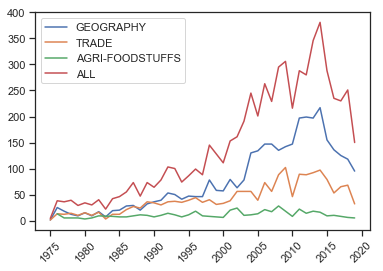

In [90]:
import seaborn as sns
sns.set(style="ticks")

# Show the results of a linear regression within each dataset
#sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
#           col_wrap=2, ci=None, palette="muted", height=4,
#           scatter_kws={"s": 50, "alpha": 1})
#for mymmev in df_mmev_count.reset_index()["mmev"].unique():
for mymmev in ["GEOGRAPHY", "TRADE", "AGRI-FOODSTUFFS"]:
    #df_plot = df_mmev_count.query("mmev == 'EUROPEAN UNION' and endYear != 'all'").reset_index().sort_values("endYear")
    df_plot = df_mmev_count.query("mmev == '%s' and endYear != 'all'" % mymmev).reset_index().sort_values("endYear")
    df_plot.endYear = df_plot.endYear.astype("int")
    #plt.figure(frameon=False)
    #sns.lineplot(x="endYear", y="count", data = df_plot, label = mymmev)
    plt.plot(df_plot["endYear"], df_plot["count"], label = mymmev)

df_year_count  = df_abc.groupby(by = ["endYear"])["cellar"].agg(lambda x: len(x.unique())).sort_values(ascending = False).to_frame().reset_index()
df_year_count = df_year_count.rename(columns = { "cellar" : "count" })
df_year_count["endYear"] = df_year_count["endYear"].astype("int")
df_year_count.sort_values("endYear", inplace = True)
plt.plot(df_year_count["endYear"], df_year_count["count"], label = "ALL")

plt.xticks(range(1975,2021,5), rotation=45)
plt.legend()
plt.savefig("output/df_mmev_count.pdf")

In [39]:
df_Form_year_count  = df_abc.groupby(by = ["Form", "endYear"])["cellar"].agg(lambda x: len(x.unique())).sort_values(ascending = False).to_frame().reset_index()
df_Form_year_count["endYear"] = df_Form_year_count["endYear"].astype("int").astype("str")
df_Form_total_count = df_abc.groupby(by = ["Form"])["cellar"].agg(lambda x: len(x.unique())).sort_values(ascending = False).to_frame().reset_index()
df_Form_total_count["endYear"] = "all"
df_Form_count = pd.concat([df_Form_total_count, df_Form_year_count])
df_Form_count = df_Form_count.rename(columns = { "cellar" : "count" }).loc[:, ["Form", "endYear", "count"]]
df_Form_count.to_csv("output/df_Form_count.dat", sep = "\t", index = False)
df_Form_count = df_Form_count.query("Form in %s" % list(df_Form_count.query("endYear == 'all' and count > 100")["Form"]))
df_Form_count

Form endYear  count
0                   Decision     all  13168
1                 Regulation     all   6622
2    Implementing regulation     all   4059
3      Implementing decision     all   1878
4                  Directive     all   1248
5             Recommendation     all    604
6       Delegated regulation     all    597
7                 Resolution     all    487
8                    Opinion     all    414
9             Special report     all    128
0                   Decision    2014    192
1                   Decision    2015    169
2                   Decision    2016    157
3                   Decision    2011    155
4                   Decision    2012    151
5                   Decision    2008    138
6                   Decision    2017    135
7                   Decision    2018    128
8                   Decision    2013    124
9                   Decision    2009    121
10                  Decision    2007    121
11                Regulation    2013    119
12                  Decision    2004    116
13                  Decision    2010    114
14                  Decision    2006    112
15                  Decision    2005    111
16                Regulation    2009    108
17                Regulation    2014    105
18                Regulation    2008    101
19                Regulation    2006     86
..                       ...     ...    ...
214           Recommendation    1993      2
215                  Opinion    2009      2
217    Implementing decision    2009      2
218  Implementing regulation    2009      2
220           Recommendation    1977      2
233           Recommendation    1981      1
234           Recommendation    1984      1
235           Recommendation    1985      1
236           Recommendation    1988      1
237           Recommendation    1989      1
238           Recommendation    1990      1
239           Recommendation    1991      1
240           Recommendation    1995      1
241           Recommendation    1997      1
242           Recommendation    2004      1
243           Recommendation    2010      1
244               Resolution    1975      1
245               Resolution    1976      1
246               Resolution    1982      1
247               Resolution    1985      1
248               Resolution    1987      1
249               Resolution    1991      1
250               Resolution    2004      1
251           Recommendation    1982      1
252           Recommendation    1978      1
260  Implementing regulation    2015      1
262  Implementing regulation    2017      1
263  Implementing regulation    2018      1
267                  Opinion    1999      1
268                  Opinion    2003      1

[243 rows x 3 columns]

Form endYear  count
0                 Decision     all   3099
1               Regulation     all   1826
2                Directive     all    770
3           Recommendation     all    206
4    Implementing decision     all    135
5                  Opinion     all    113
6               Resolution     all    109
0                 Decision    2014    192
1                 Decision    2015    169
2                 Decision    2016    157
3                 Decision    2011    155
4                 Decision    2012    151
5                 Decision    2008    138
6                 Decision    2017    135
7                 Decision    2018    128
8                 Decision    2013    124
9                 Decision    2009    121
10                Decision    2007    121
11              Regulation    2013    119
12                Decision    2004    116
13                Decision    2010    114
14                Decision    2006    112
15                Decision    2005    111
16              Regulation    2009    108
17              Regulation    2014    105
18              Regulation    2008    101
19              Regulation    2006     86
20                Decision    2001     86
21                Decision    2019     83
22                Decision    2003     81
..                     ...     ...    ...
207             Resolution    1988      2
209             Resolution    1980      2
211         Recommendation    2007      2
213         Recommendation    1976      2
214         Recommendation    1993      2
215                Opinion    2009      2
217  Implementing decision    2009      2
220         Recommendation    1977      2
233         Recommendation    1981      1
234         Recommendation    1984      1
235         Recommendation    1985      1
236         Recommendation    1988      1
237         Recommendation    1989      1
238         Recommendation    1990      1
239         Recommendation    1991      1
240         Recommendation    1995      1
241         Recommendation    1997      1
242         Recommendation    2004      1
243         Recommendation    2010      1
244             Resolution    1975      1
245             Resolution    1976      1
246             Resolution    1982      1
247             Resolution    1985      1
248             Resolution    1987      1
249             Resolution    1991      1
250             Resolution    2004      1
251         Recommendation    1982      1
252         Recommendation    1978      1
267                Opinion    1999      1
268                Opinion    2003      1

[230 rows x 3 columns]

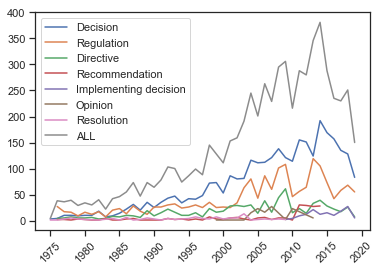

In [146]:
for myForm in df_Form_count.reset_index()["Form"].unique():
    #print(myForm)
    #df_plot = df_mmev_count.query("mmev == 'EUROPEAN UNION' and endYear != 'all'").reset_index().sort_values("endYear")
    df_plot = df_Form_count.query("Form == '%s' and endYear != 'all'" % myForm).reset_index().sort_values("endYear")
    df_plot.endYear = df_plot.endYear.astype("int")
    #plt.figure(frameon=False)
    #sns.lineplot(x="endYear", y="count", data = df_plot, label = mymmev)
    plt.plot(df_plot["endYear"], df_plot["count"], label = myForm)

df_year_Form_count  = df_abc.groupby(by = ["endYear"])["cellar"].agg(lambda x: len(x.unique())).sort_values(ascending = False).to_frame().reset_index()
df_year_Form_count  = df_year_Form_count.rename(columns = { "cellar" : "count" })
df_year_Form_count["endYear"] = df_year_Form_count["endYear"].astype("int")
df_year_Form_count.sort_values("endYear", inplace = True)
plt.plot(df_year_Form_count["endYear"], df_year_Form_count["count"], label = "ALL")

plt.xticks(range(1975,2021,5), rotation=45)
plt.legend()
plt.savefig("output/df_Form_count.pdf")

/Users/sstolzen/mypackages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


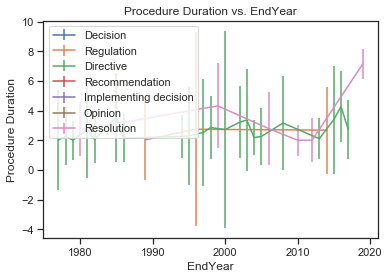

In [147]:
df_procdur_by_Form_year = df_abc.groupby(["Form", "endYear"])["Proc_Dur"].agg({ "Average Procedure Duration": np.mean, "Standard deviation" : np.std} ).sort_values("Average Procedure Duration", ascending = False).reset_index()
df_procdur_by_Form_year["endYear"] = df_procdur_by_year["endYear"].astype("int")
df_procdur_by_Form_year.sort_values("endYear", inplace = True)
df_procdur_by_Form_year

for myForm in df_Form_count.reset_index()["Form"].unique():
    df_plot = df_procdur_by_Form_year.query("Form == '%s'" % myForm)
    #plt.plot(df_procdur_by_year["endYear"], df_procdur_by_year["Average Procedure Duration"],label = "ALL")
    plt.errorbar(df_plot["endYear"], df_plot["Average Procedure Duration"], df_plot["Standard deviation"],label = myForm)
    #plt.xticks(range(1975,2021,5), rotation=45)
    plt.legend()
    plt.title("Procedure Duration vs. EndYear")
    plt.xlabel("EndYear")
    plt.ylabel("Procedure Duration")
    #plt.savefig("output/df_procedure_duration_by_Form_year.pdf")

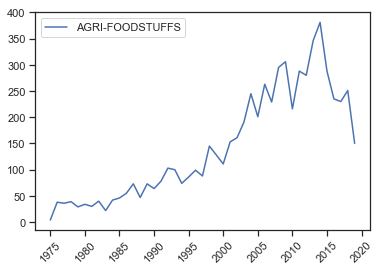

In [84]:
df_plot = df_year_count.sort_values("endYear")
df_plot.endYear = df_plot.endYear.astype("int")
#plt.figure(frameon=False)
#sns.lineplot(x="endYear", y="count", data = df_plot, label = mymmev)
plt.plot(df_plot["endYear"], df_plot["count"], label = mymmev)
plt.xticks(range(1975,2021,5), rotation=45)
#plt.legend()
plt.savefig("output/df_mmev_count.pdf")

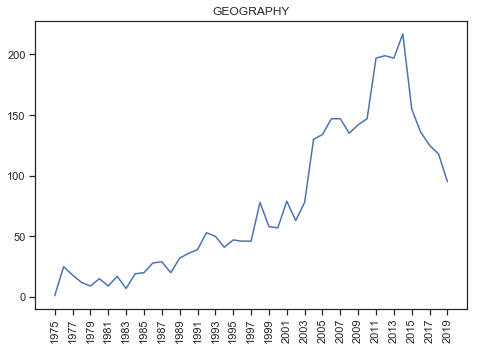

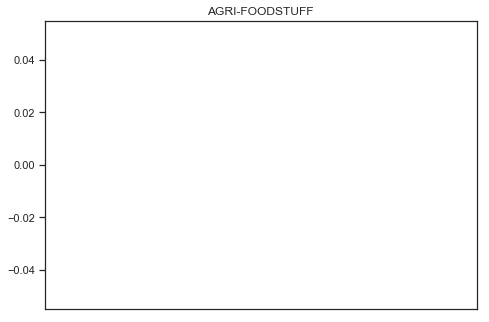

In [31]:
import seaborn as sns
sns.set(style="ticks")

#for mymmev in df_mmev_count.reset_index()["mmev"].unique():
for mymmev in ["GEOGRAPHY", "AGRI-FOODSTUFF"]:
    #df_plot = df_mmev_count.query("mmev == 'EUROPEAN UNION' and endYear != 'all'").reset_index().sort_values("endYear")
    df_plot = df_mmev_count.query("mmev == '%s' and endYear != 'all'" % mymmev).reset_index().sort_values("endYear")
    fig = plt.figure()
    plt.axes(frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])
    #ax.axis('off')
    plt.plot(df_plot["endYear"], df_plot["count"])
    plt.xticks(df_plot["endYear"][::2],rotation='vertical')
    plt.title(mymmev)
    plt.savefig("output/df_mmev_count.%s.pdf" % mymmev)
    print()

In [105]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///output/df_mmev_count.db', encoding="utf8", echo=True)
#df_mmev_count = pd.read_csv("output/df_mmev_count.dat", sep = "\t")
#engine = create_engine('sqlite:///output/df_mmev_count.db?charset=utf8mb4', echo=False)
df_mmev_count.to_sql('df_mmev_count', con=engine)
#engine.execute("SELECT * FROM df_mmev_count").fetchall()
#engine.execute("ALTER TABLE 'df_mmev_count' ADD PRIMARY KEY (mmev,endYear)").fetchall()
#engine.execute("ALTER TABLE 'df_mmev_count' ALTER COLUMN ('mmev','endYear') RESTART WITH 1").fetchall()
#engine.execute("ALTER TABLE df_mmev_count ADD CONSTRAINT PK_df_mmev_count PRIMARY KEY (mmev, endYear)").fetchall()

2019-05-23 11:43:34,889 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-23 11:43:34,889 INFO sqlalchemy.engine.base.Engine ()
2019-05-23 11:43:34,891 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-23 11:43:34,892 INFO sqlalchemy.engine.base.Engine ()
2019-05-23 11:43:34,895 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("df_mmev_count")
2019-05-23 11:43:34,896 INFO sqlalchemy.engine.base.Engine ()
2019-05-23 11:43:34,901 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE df_mmev_count (
	mmev TEXT, 
	"endYear" TEXT, 
	count BIGINT
)


2019-05-23 11:43:34,902 INFO sqlalchemy.engine.base.Engine ()
2019-05-23 11:43:34,906 INFO sqlalchemy.engine.base.Engine COMMIT
2019-05-23 11:43:34,907 INFO sqlalchemy.engine.base.Engine CREATE INDEX ix_df_mmev_count_mmev ON df_mmev_count (mmev)
2019-05-23 11:43:34,909 INFO sqlalchemy.engine.base.Engine ()
2019-05-23 11:43:34,913 INFO sqlalch

OperationalError: (sqlite3.OperationalError) near "CONSTRAINT": syntax error
[SQL: ALTER TABLE df_mmev_count ADD CONSTRAINT PK_df_mmev_count PRIMARY KEY (mmev, endYear)]
(Background on this error at: http://sqlalche.me/e/e3q8)

In [57]:
df_abc = df_abc.query("startYear > 1900").copy()
df_abc["Proc_Dur"] = df_abc["endYear"] - df_abc["startYear"]
df_out = df_abc.groupby(["mmID", "mmev"])["Proc_Dur"].agg({ "Average": np.mean, "Standard deviation" : np.std} ).sort_values("Average", ascending = False)
df_out.to_excel("output/df_avg_procedure_duration.xlsx")
df_out.to_csv("output/df_avg_procedure_duration.tsv", sep = "\t")
df_out
#df_abc.groupby("mmev")["Proc_Dur"].agg("max").sort_values(ascending = False)
#df_abc.groupby("mmev")["Proc_Dur"].agg("mean").sort_values(ascending = False)

/home/mi/sstolzen/mystore/mypackages/miniconda3/envs/python34/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


Standard deviation   Average
mmID mmev                                                             
36   SCIENCE                                        1.949998  1.955224
48   TRANSPORT                                      2.212692  1.534360
12   LAW                                            2.206324  1.492590
28   SOCIAL QUESTIONS                               1.884001  1.455654
32   EDUCATION AND COMMUNICATIONS                   1.568819  1.423407
52   ENVIRONMENT                                    1.640442  1.400981
64   PRODUCTION, TECHNOLOGY AND RESEARCH            1.567328  1.298291
4    POLITICS                                       1.607019  1.078019
40   BUSINESS AND COMPETITION                       1.770795  1.050797
60   AGRI-FOODSTUFFS                                1.953624  1.025281
66   ENERGY                                         1.228937  0.981818
44   EMPLOYMENT AND WORKING CONDITIONS              1.953466  0.951537
10   EUROPEAN UNION                                 1.647755  0.941404
20   TRADE                                          1.578155  0.921656
8    INTERNATIONAL RELATIONS                        1.340724  0.849442
68   INDUSTRY                                       1.328899  0.778677
56   AGRICULTURE, FORESTRY AND FISHERIES            1.176749  0.732528
76   INTERNATIONAL ORGANISATIONS                    1.063844  0.621818
72   GEOGRAPHY                                      1.405249  0.618436
24   FINANCE                                        1.126545  0.586241
16   ECONOMICS                                      1.134057  0.581701

/Users/sstolzen/mypackages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


Average  Standard deviation
mmev                                                             
SCIENCE                              1.955224            1.957370
TRANSPORT                            1.534360            2.213020
LAW                                  1.492590            2.206651
SOCIAL QUESTIONS                     1.455654            1.884262
EDUCATION AND COMMUNICATIONS         1.423462            1.568596
ENVIRONMENT                          1.400981            1.640694
PRODUCTION, TECHNOLOGY AND RESEARCH  1.298291            1.567663
POLITICS                             1.078261            1.610008
BUSINESS AND COMPETITION             1.050827            1.771842
AGRI-FOODSTUFFS                      1.025281            1.954311
ENERGY                               0.981818            1.229559
EMPLOYMENT AND WORKING CONDITIONS    0.951590            1.952760
EUROPEAN UNION                       0.941394            1.647963
TRADE                                0.921656            1.578265
INTERNATIONAL RELATIONS              0.849442            1.340804
INDUSTRY                             0.778677            1.329348
AGRICULTURE, FORESTRY AND FISHERIES  0.732744            1.176866
INTERNATIONAL ORGANISATIONS          0.621818            1.064814
GEOGRAPHY                            0.618436            1.405327
FINANCE                              0.586241            1.126638
ECONOMICS                            0.582360            1.134030

/Users/sstolzen/mypackages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


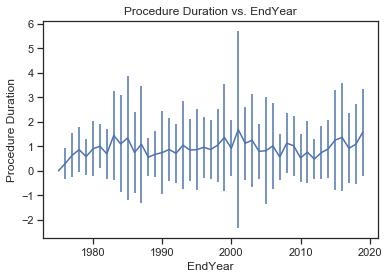

In [111]:
df_procdur_by_year = df_abc.groupby("endYear")["Proc_Dur"].agg({ "Average Procedure Duration": np.mean, "Standard deviation" : np.std} ).sort_values("Average Procedure Duration", ascending = False).reset_index()
df_procdur_by_year["endYear"] = df_procdur_by_year["endYear"].astype("int")
df_procdur_by_year.sort_values("endYear", inplace = True)
df_procdur_by_year
#plt.plot(df_procdur_by_year["endYear"], df_procdur_by_year["Average Procedure Duration"],label = "ALL")
plt.errorbar(df_procdur_by_year["endYear"], df_procdur_by_year["Average Procedure Duration"], df_procdur_by_year["Standard deviation"],label = "ALL")
#plt.xticks(range(1975,2021,5), rotation=45)
#plt.legend()
plt.title("Procedure Duration vs. EndYear")
plt.xlabel("EndYear")
plt.ylabel("Procedure Duration")
plt.savefig("output/df_procedure_duration.pdf")

In [97]:
df_out = df_abc.groupby("Form")["cellar"].agg( lambda x : len(x.unique()) ).sort_values(ascending = False)
#df_out.to_excel("output/df_avg_procedure_duration.xlsx")
df_out
#df_abc.groupby("mmev")["Proc_Dur"].agg("max").sort_values(ascending = False)
#df_abc.groupby("mmev")["Proc_Dur"].agg("mean").sort_values(ascending = False)

Form
Decision                                     3099
Regulation                                   1826
Directive                                     770
Recommendation                                206
Implementing decision                         135
Opinion                                       113
Resolution                                    109
Implementing regulation                        67
Framework decision                             20
Conclusions                                    14
Initiative                                     12
Common position                                 4
Programme                                       3
Financial regulation                            3
Budget                                          2
Supplementary and amending budget               2
Declaration                                     2
Decision Decision                               1
Interinstitutional agreement                    1
Proposal for a decision without addressee    

In [58]:
df_eurovoc_doc_full_h5 = df_eurovoc_doc_full.copy()
df_eurovoc_doc_full_h5.loc[:, df_eurovoc_doc_full_h5.dtypes == object] = \
df_eurovoc_doc_full_h5.loc[:, df_eurovoc_doc_full_h5.dtypes == object].astype("str")
df_eurovoc_doc_full_h5.to_hdf("output/df_eurovoc_doc_full.h5", 
                              "df_eurovoc_doc_full", 
                              compression = 9,
                              mode = "w")

In [2]:
df_eurovoc_doc = pd.read_hdf("output/df_eurovoc_doc_full.h5")
df_eurovoc_doc.head()

ImportError: HDFStore requires PyTables, "No module named 'tables'" problem importing

In [60]:
df_eurovoc_doc_full.query("ProcTitle != ProcTitle")

cellar      ID  \
0       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966   
1       f3931f63-15d2-11e7-808e-01aa75ed71a1  434966   
2       f3931f63-15d2-11e7-808e-01aa75ed71a1    4195   
3       f3931f63-15d2-11e7-808e-01aa75ed71a1    4195   
4       f3931f63-15d2-11e7-808e-01aa75ed71a1    2098   
5       f3931f63-15d2-11e7-808e-01aa75ed71a1    2098   
6       f3931f63-15d2-11e7-808e-01aa75ed71a1    1459   
7       f3931f63-15d2-11e7-808e-01aa75ed71a1    1459   
8       f3931f63-15d2-11e7-808e-01aa75ed71a1     560   
9       f3931f63-15d2-11e7-808e-01aa75ed71a1     560   
10      f3931f63-15d2-11e7-808e-01aa75ed71a1    4491   
11      f3931f63-15d2-11e7-808e-01aa75ed71a1    4491   
12      f3931f63-15d2-11e7-808e-01aa75ed71a1     248   
13      f3931f63-15d2-11e7-808e-01aa75ed71a1     248   
14      f3931f63-15d2-11e7-808e-01aa75ed71a1    5235   
15      f3931f63-15d2-11e7-808e-01aa75ed71a1    5235   
16      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966   
17      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434966   
18      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434880   
19      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434880   
20      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    1318   
21      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    1318   
22      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434004   
23      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1  434004   
24      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    4668   
25      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    4668   
26      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    5650   
27      e7e0c788-4d2a-11e3-ae03-01aa75ed71a1    5650   
28      0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966   
29      0053cbe4-8290-11e3-9b7d-01aa75ed71a1  434966   
...                                      ...     ...   
360092  9e1c15a8-a78a-49f9-8162-a5a19abc41a0    4316   
360093  9e1c15a8-a78a-49f9-8162-a5a19abc41a0    4316   
360094  9e1c15a8-a78a-49f9-8162-a5a19abc41a0    4315   
360095  9e1c15a8-a78a-49f9-8162-a5a19abc41a0    4315   
360096  9e1c15a8-a78a-49f9-8162-a5a19abc41a0     276   
360097  9e1c15a8-a78a-49f9-8162-a5a19abc41a0     276   
360098  9e1c15a8-a78a-49f9-8162-a5a19abc41a0    4170   
360099  9e1c15a8-a78a-49f9-8162-a5a19abc41a0    4170   
360100  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4316   
360101  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4316   
360102  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4315   
360103  096621a4-dcb2-4b27-bfe8-ba065ed74aa6    4315   
360104  096621a4-dcb2-4b27-bfe8-ba065ed74aa6     276   
360105  096621a4-dcb2-4b27-bfe8-ba065ed74aa6     276   
360106  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4316   
360107  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4316   
360108  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4315   
360109  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4315   
360110  eba0dff1-76da-49dc-9720-87fe3dc2d9b9     276   
360111  eba0dff1-76da-49dc-9720-87fe3dc2d9b9     276   
360112  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4170   
360113  eba0dff1-76da-49dc-9720-87fe3dc2d9b9    4170   
360114  1bbc4f25-e703-490c-90ed-e78ab8824020     431   
360115  1bbc4f25-e703-490c-90ed-e78ab8824020     431   
360116  1bbc4f25-e703-490c-90ed-e78ab8824020      86   
360117  1bbc4f25-e703-490c-90ed-e78ab8824020      86   
360122  c39db218-5762-4144-b3e3-25db533e2565     431   
360123  c39db218-5762-4144-b3e3-25db533e2565     431   
360128  ec382043-7490-4031-a126-f1ec17e40a28    1433   
360129  ec382043-7490-4031-a126-f1ec17e40a28    1433   

                                 ev   mID  \
0                emission allowance  5206   
1                emission allowance  5206   
2                investment company  2416   
3                investment company  2416   
4                              bond  2421   
5                              bond  2421   
6              financial instrument  2421   
7              financial instrument  2421   
8             financial legislation  2421   
9             financial legislation  2421   
10            financial transaction  2421   
11            financial t

In [68]:
l_eurovoc_unq = df_eurovoc_doc["ev"].unique()
df_commoncount = pd.DataFrame(0, index = l_eurovoc_unq, columns = l_eurovoc_unq)
#df_commoncount
def countcommons(x):
    assert len(x) == len(np.unique(x))
    df_commoncount.loc[x, x] += 1
df_eurovoc_doc.groupby("cellar")["ev"].agg(countcommons)
df_commoncount.head()

emission allowance  \
emission allowance                                                9   
activity report                                                   0   
Agency for the Cooperation of Energy Regulators                   0   
ACP countries                                                     0   
ACP-EU Committee of Ambassadors                                   0   

                                                 activity report  \
emission allowance                                             0   
activity report                                               43   
Agency for the Cooperation of Energy Regulators                0   
ACP countries                                                  0   
ACP-EU Committee of Ambassadors                                0   

                                                 Agency for the Cooperation of Energy Regulators  \
emission allowance                                                                             0   
activity report                                                                                0   
Agency for the Cooperation of Energy Regulators                                                5   
ACP countries                                                                                  0   
ACP-EU Committee of Ambassadors                                                                0   

                                                 ACP countries  \
emission allowance                                           0   
activity report                                              0   
Agency for the Cooperation of Energy Regulators              0   
ACP countries                                               83   
ACP-EU Committee of Ambassadors                              3   

                                                 ACP-EU Committee of Ambassadors  \
emission allowance                                                             0   
activity report                                                                0   
Agency for the Cooperation of Energy Regulators                                0   
ACP countries                                                                  3   
ACP-EU Committee of Ambassadors                                                5   

                                                 ACP-EU Convention  \
emission allowance                                               0   
activity report                                                  0   
Agency for the Cooperation of Energy Regulators                  0   
ACP countries                                                    5   
ACP-EU Committee of Ambassadors                                  2   

                                                 ACP-EU Council of Ministers  \
emission allowance                                                         0   
activity report                                                            0   
Agency for the Cooperation of Energy Regulators                            0   
ACP countries                                                              0   
ACP-EU Committee of Ambassadors                                            0   

                                                 ACP-EU institution  \
emission allowance                                                0   
activity report                                                   0   
Agency for the Cooperation of Energy Regulators                   0   
ACP countries                                                     0   
ACP-EU Committee of Ambassadors                                   0   

                                                 ACP-EU relationship  \
emission allowance                                                 0   
activity report                                                    0   
Agency for the Cooperation of Energy Regulators                    0   
ACP countries                                                      3   
ACP-EU Committee of A

In [69]:
len(l_eurovoc_unq)

4842

In [39]:
l_eurovoc_unq = df_eurovoc_doc["mmev"].unique()
#print(l_eurovoc_unq)
df_commoncount_mmev = pd.DataFrame(0, index = l_eurovoc_unq, columns = l_eurovoc_unq)
#display(df_commoncount_mmev.head())
def countcommons(x):
    #assert len(x) == len(np.unique(x))
    df_commoncount_mmev.loc[x.unique(), x.unique()] += 1
df_eurovoc_doc.groupby("cellar")["mmev"].agg(countcommons)
df_commoncount_mmev.head()

ENVIRONMENT  FINANCE  \
ENVIRONMENT                                 3373      100   
FINANCE                                      100     4188   
PRODUCTION, TECHNOLOGY AND RESEARCH          755      484   
GEOGRAPHY                                    951     2121   
INTERNATIONAL RELATIONS                      654      784   

                                     PRODUCTION, TECHNOLOGY AND RESEARCH  \
ENVIRONMENT                                                          755   
FINANCE                                                              484   
PRODUCTION, TECHNOLOGY AND RESEARCH                                 4130   
GEOGRAPHY                                                            998   
INTERNATIONAL RELATIONS                                              779   

                                     GEOGRAPHY  INTERNATIONAL RELATIONS  \
ENVIRONMENT                                951                      654   
FINANCE                                   2121                      784   
PRODUCTION, TECHNOLOGY AND RESEARCH        998                      779   
GEOGRAPHY                                14395                     4491   
INTERNATIONAL RELATIONS                   4491                     7492   

                                     TRADE  INDUSTRY  \
ENVIRONMENT                           1185       895   
FINANCE                               1002       297   
PRODUCTION, TECHNOLOGY AND RESEARCH   1736       982   
GEOGRAPHY                             5564      1749   
INTERNATIONAL RELATIONS               2390       558   

                                     AGRICULTURE, FORESTRY AND FISHERIES  \
ENVIRONMENT                                                         1239   
FINANCE                                                              388   
PRODUCTION, TECHNOLOGY AND RESEARCH                                  920   
GEOGRAPHY                                                           3932   
INTERNATIONAL RELATIONS                                             1385   

                                     TRANSPORT  EUROPEAN UNION  ...  \
ENVIRONMENT                                516             956  ...   
FINANCE                                    256            1927  ...   
PRODUCTION, TECHNOLOGY AND RESEARCH        834            1343  ...   
GEOGRAPHY                                 1279            5985  ...   
INTERNATIONAL RELATIONS                    752            4547  ...   

                                     INTERNATIONAL ORGANISATIONS  \
ENVIRONMENT                                                   67   
FINANCE                                                       38   
PRODUCTION, TECHNOLOGY AND RESEARCH                          121   
GEOGRAPHY                                                    204   
INTERNATIONAL RELATIONS                                      314   

                                     EDUCATION AND COMMUNICATIONS  ECONOMICS  \
ENVIRONMENT                                                   443        307   
FINANCE                                                       710       1357   
PRODUCTION, TECHNOLOGY AND RESEARCH                          1003        415   
GEOGRAPHY                                                    1024       3016   
INTERNATIONAL RELATIONS                                       781       1117   

                                     EMPLOYMENT AND WORKING CONDITIONS  \
ENVIRONMENT                                                         84   
FINANCE                                                            398   
PRODUCTION, TECHNOLOGY AND RESEARCH                                178   
GEOGRAPHY                                                          629   
INTERNATIONAL RELATIONS                                            316   

                                     SOCIAL QUESTIONS  ENERGY  \
ENVIRONMENT                                      1064     408   
FINANCE                                           296     152   
PRODUCTION,

In [47]:
#np.fill_diagonal(df_commoncount_mmev.values, 0)

In [49]:
df_commoncount_mmev.to_csv("output/df_commoncount_mmev.dat", sep = "\t", index = True)
df_commoncount_mmev

ENVIRONMENT  FINANCE  \
ENVIRONMENT                                 3373      100   
FINANCE                                      100     4188   
PRODUCTION, TECHNOLOGY AND RESEARCH          755      484   
GEOGRAPHY                                    951     2121   
INTERNATIONAL RELATIONS                      654      784   
TRADE                                       1185     1002   
INDUSTRY                                     895      297   
AGRICULTURE, FORESTRY AND FISHERIES         1239      388   
TRANSPORT                                    516      256   
EUROPEAN UNION                               956     1927   
POLITICS                                     153      411   
INTERNATIONAL ORGANISATIONS                   67       38   
EDUCATION AND COMMUNICATIONS                 443      710   
ECONOMICS                                    307     1357   
EMPLOYMENT AND WORKING CONDITIONS             84      398   
SOCIAL QUESTIONS                            1064      296   
ENERGY                                       408      152   
BUSINESS AND COMPETITION                     263     1236   
AGRI-FOODSTUFFS                              457      331   
LAW                                          193      478   
SCIENCE                                      114        7   

                                     PRODUCTION, TECHNOLOGY AND RESEARCH  \
ENVIRONMENT                                                          755   
FINANCE                                                              484   
PRODUCTION, TECHNOLOGY AND RESEARCH                                 4130   
GEOGRAPHY                                                            998   
INTERNATIONAL RELATIONS                                              779   
TRADE                                                               1736   
INDUSTRY                                                             982   
AGRICULTURE, FORESTRY AND FISHERIES                                  920   
TRANSPORT                                                            834   
EUROPEAN UNION                                                      1343   
POLITICS                                                             185   
INTERNATIONAL ORGANISATIONS                                          121   
EDUCATION AND COMMUNICATIONS                                        1003   
ECONOMICS                                                            415   
EMPLOYMENT AND WORKING CONDITIONS                                    178   
SOCIAL QUESTIONS                                                     889   
ENERGY                                                               264   
BUSINESS AND COMPETITION                                             539   
AGRI-FOODSTUFFS                                                      615   
LAW                                                                  243   
SCIENCE                                                              117   

                                     GEOGRAPHY  INTERNATIONAL RELATIONS  \
ENVIRONMENT                                951                      654   
FINANCE                                   2121                      784   
PRODUCTION, TECHNOLOGY AND RESEARCH        998                      779   
GEOGRAPHY                                14395                     4491   
INTERNATIONAL RELATIONS                   4491                     7492   
TRADE                                     5564                     2390   
INDUSTRY                                  1749                      558   
AGRICULTURE, FORESTRY AND FISHERIES       3932                     1385   
TRANSPORT                                 1279                      752   
EUROPEAN UNION                            5985                     4547   
POLITICS                                  1032                     1051   
INTERNATIONAL ORGANISATIONS                204                      314   
EDUCATION AND COMMUNICATIONS              1024

In [152]:
df_commoncount_mmev.sum().sort_values(ascending = False)

GEOGRAPHY                              42794
TRADE                                  37158
EUROPEAN UNION                         34570
AGRICULTURE, FORESTRY AND FISHERIES    24987
INTERNATIONAL RELATIONS                24091
SOCIAL QUESTIONS                       19266
AGRI-FOODSTUFFS                        19063
ECONOMICS                              15349
INDUSTRY                               14345
BUSINESS AND COMPETITION               14190
PRODUCTION, TECHNOLOGY AND RESEARCH    13400
FINANCE                                12773
EDUCATION AND COMMUNICATIONS           12606
ENVIRONMENT                            10804
LAW                                     9764
TRANSPORT                               8756
POLITICS                                7989
EMPLOYMENT AND WORKING CONDITIONS       5386
ENERGY                                  4387
SCIENCE                                 2131
INTERNATIONAL ORGANISATIONS             1791
dtype: int64

In [154]:
df_commoncount = pd.read_csv("output/df_commoncount.dat", index_col = 0)
df_commoncount

emission allowance  \
emission allowance                                                9   
activity report                                                   0   
Agency for the Cooperation of Energy Regulators                   0   
ACP countries                                                     0   
ACP-EU Committee of Ambassadors                                   0   
ACP-EU Convention                                                 0   
ACP-EU Council of Ministers                                       0   
ACP-EU institution                                                0   
ACP-EU relationship                                               0   
administrator                                                     0   
ADN agreement                                                     0   
ADR agreement                                                     0   
alternative dispute resolution                                    0   
AETR agreement                                                    0   
area of freedom, security and justice                             0   
AIDS                                                              0   
anti-personnel weapon                                             0   
European Joint Undertaking                                        0   
ASEAN                                                             0   
ASEAN countries                                                   0   
assistant                                                         0   
electronic banking                                                0   
African Union                                                     0   
Abruzzi                                                           0   
EU body for police and judicial cooperation                       0   
Yemen                                                             0   
Adriatic Sea                                                      0   
diploma                                                           0   
member of the Court of Justice (EU)                               0   
Aegean Islands                                                    0   
...                                                             ...   
withdrawal price                                                  0   
woman                                                             0   
women's rights                                                    0   
wood industry                                                     0   
wood production                                                   0   
wool                                                              0   
youth employment                                                  0   
work permit                                                       0   
work schedule                                                     0   
worker information                                                0   
workers' movement                                                 0   
working capital                                                   0   
working conditions                                                0   
working population                                                0   
working population engaged in agriculture                         0   
workplace                                                         0   
world market price                                                0   
xenophobia                                                        0   
yam                                                               0   
yoghourt                                                          0   
young farmer                                                      0   
young worker                                                      0   
youth exchange scheme                                             0   
youth policy                                                      0   
youth unemployment                                                0   
zi

In [158]:
df_commoncount["reduction of gas emissions"].sort_values(ascending =False).to_excel("output/df_commoncount_reduction_of_gas_emissions.xlsx")

In [50]:
list(G.adjacency())

NameError: name 'G' is not defined

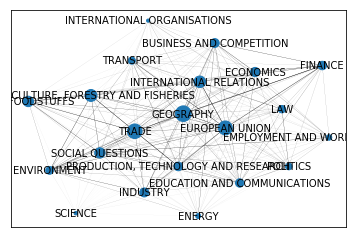

In [55]:
mynode_size = sklearn.preprocessing.normalize(df_commoncount_mmev.sum().astype("float").values.reshape(1, -1) )
adj = sklearn.preprocessing.normalize(df_commoncount_mmev.astype("float"))

#np.fill_diagonal(adj, 0)

G = nx.from_numpy_matrix(adj)

#pos = nx.circular_layout(G)
pos = nx.spring_layout(G)
edges = G.edges()
#colors = [G[u][v]['color'] for u,v in edges]
#weights = [G[u][v]['weight'] for u,v in edges]
weights = [adj[i] for i in edges]

labeldict = { i : lbl for i, lbl in enumerate(df_commoncount_mmev.index) }

#nx.draw(G, pos, edges=edges, edge_color=colors, width=weights))
nx.draw_networkx_nodes(G, pos,
                       node_size= 500 * mynode_size)
nx.draw_networkx_labels(G, pos, 
                        labels=labeldict, 
                        font_size= 10)
nx.draw_networkx_edges(G, pos,
                       edges=edges,
                       width=weights)

#nx.draw(G, pos,        
#        edges=edges,
#        labels=labeldict,
#        width=weights,
#        node_size= 500 * mynode_size,
#        with_labels=True)
#colors


print()

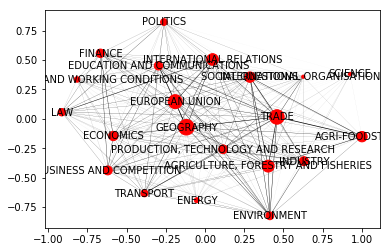

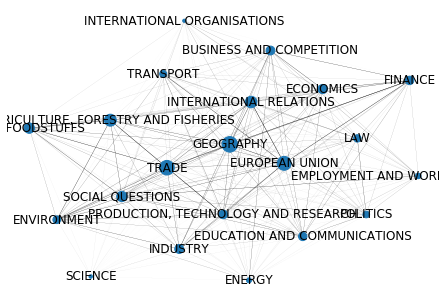

In [56]:
nx.draw(G, pos,        
        edges=edges,
        labels=labeldict,
        width=weights,
        node_size= 500 * mynode_size,
        with_labels=True)
plt.savefig("output/metametatopic_cooccurences.pdf")

In [71]:
df_commoncount_mmev_s = df_commoncount_mmev.stack().sort_values(ascending = False).to_frame().reset_index().query("level_0 != level_1")
blockpair = [["level_0"], ["level_1"]]
order(df_commoncount_mmev_s, blockpair)
df_commoncount_mmev_s.drop_duplicates(inplace = True)
df_commoncount_mmev_s

level_0                              level_1  \
6                         EUROPEAN UNION                            GEOGRAPHY   
9                              GEOGRAPHY                                TRADE   
11                       AGRI-FOODSTUFFS                                TRADE   
13   AGRICULTURE, FORESTRY AND FISHERIES                                TRADE   
17                        EUROPEAN UNION              INTERNATIONAL RELATIONS   
19                             GEOGRAPHY              INTERNATIONAL RELATIONS   
25   AGRICULTURE, FORESTRY AND FISHERIES                            GEOGRAPHY   
27                       AGRI-FOODSTUFFS  AGRICULTURE, FORESTRY AND FISHERIES   
31                              INDUSTRY                                TRADE   
33                       AGRI-FOODSTUFFS                            GEOGRAPHY   
35                             ECONOMICS                            GEOGRAPHY   
38                        EUROPEAN UNION                                TRADE   
40                      SOCIAL QUESTIONS                                TRADE   
42   AGRICULTURE, FORESTRY AND FISHERIES                     SOCIAL QUESTIONS   
44              BUSINESS AND COMPETITION                            GEOGRAPHY   
47               INTERNATIONAL RELATIONS                                TRADE   
49   AGRICULTURE, FORESTRY AND FISHERIES                       EUROPEAN UNION   
51                               FINANCE                            GEOGRAPHY   
53                       AGRI-FOODSTUFFS                     SOCIAL QUESTIONS   
55                        EUROPEAN UNION                              FINANCE   
57                        EUROPEAN UNION                     SOCIAL QUESTIONS   
59                             GEOGRAPHY                     SOCIAL QUESTIONS   
61                             ECONOMICS                       EUROPEAN UNION   
63                             GEOGRAPHY                             INDUSTRY   
65   PRODUCTION, TECHNOLOGY AND RESEARCH                                TRADE   
68              BUSINESS AND COMPETITION                            ECONOMICS   
70                             GEOGRAPHY                                  LAW   
72          EDUCATION AND COMMUNICATIONS                       EUROPEAN UNION   
74              BUSINESS AND COMPETITION                       EUROPEAN UNION   
76                        EUROPEAN UNION                                  LAW   
..                                   ...                                  ...   
381                      AGRI-FOODSTUFFS                             POLITICS   
383         EDUCATION AND COMMUNICATIONS          INTERNATIONAL ORGANISATIONS   
385                          ENVIRONMENT          INTERNATIONAL ORGANISATIONS   
387          INTERNATIONAL ORGANISATIONS                                  LAW   
388              INTERNATIONAL RELATIONS                              SCIENCE   
391                            ECONOMICS          INTERNATIONAL ORGANISATIONS   
393  AGRICULTURE, FORESTRY AND FISHERIES          INTERNATIONAL ORGANISATIONS   
395                               ENERGY                             POLITICS   
396          INTERNATIONAL ORGANISATIONS                             POLITICS   
397    EMPLOYMENT AND WORKING CONDITIONS                               ENERGY   
401                             INDUSTRY          INTERNATIONAL ORGANISATIONS   
402                               ENERGY                                  LAW   
405                      AGRI-FOODSTUFFS                               ENERGY   
407  AGRICULTURE, FORESTRY AND FISHERIES                               ENERGY   
409          INTERNATIONAL ORGANISATIONS                     SOCIAL QUESTIONS   
411                              FINANCE          INTERNATIONAL ORGANISATIONS   
413             BUSINESS AND COMPETITION          INTERNATIONAL ORGANISATIONS   
415                                  LAW                        

In [257]:
#df_eurovoc_doc.groupby("cellar")["eurovoc"].agg(lambda x: len(x))
#len(df_eurovoc_doc["cellar"].unique())
df_commoncount = pd.read_hdf("output/df_commoncount.h5")
df_commoncount.to_csv("output/df_commoncount.tsv", sep = "\t", index = True)
#df_commoncount.to_hdf("output/df_commoncount.h5", key = "df_commoncount", mode = "w", format = "fixed", complevel = 9)

In [233]:
df_commoncount = pd.read_hdf("output/df_commoncount.h5")
df_commoncount = df_commoncount.unstack().reset_index()
df_commoncount.columns = ["ev1", "ev2", "commoncount"]
df_commoncount = df_commoncount.query("ev1 != ev2 and commoncount > 0")
df_commoncount = df_commoncount.sort_values(by = ["ev1", "commoncount"], ascending = [True, False])

In [254]:
#df_commoncount.groupby("ev1").agg(lambda x: x.iloc[:2])
numtops = 10
mygroup = df_commoncount.groupby("ev1")
mygroup["ev2"].transform('size')
#flags = (mygroup.cumcount() + 1) <= g["ev2"].transform('size') * n
flags = (mygroup.cumcount() + 1) <= numtops
df_commoncount.loc[flags].reset_index(drop = True).to_csv("output/df_commoncount_sparse_top_%d_for_each_Eurovoc.tsv" % numtops, index = False, sep = "\t")

In [299]:
df_commoncount.dot()

emission allowance  \
emission allowance                                                9   
activity report                                                   0   
Agency for the Cooperation of Energy Regulators                   0   
ACP countries                                                     0   
ACP-EU Committee of Ambassadors                                   0   
ACP-EU Convention                                                 0   
ACP-EU Council of Ministers                                       0   
ACP-EU institution                                                0   
ACP-EU relationship                                               0   
administrator                                                     0   
ADN agreement                                                     0   
ADR agreement                                                     0   
alternative dispute resolution                                    0   
AETR agreement                                                    0   
area of freedom, security and justice                             0   
AIDS                                                              0   
anti-personnel weapon                                             0   
European Joint Undertaking                                        0   
ASEAN                                                             0   
ASEAN countries                                                   0   
assistant                                                         0   
electronic banking                                                0   
African Union                                                     0   
Abruzzi                                                           0   
EU body for police and judicial cooperation                       0   
Yemen                                                             0   
Adriatic Sea                                                      0   
diploma                                                           0   
member of the Court of Justice (EU)                               0   
Aegean Islands                                                    0   
...                                                             ...   
withdrawal price                                                  0   
woman                                                             0   
women's rights                                                    0   
wood industry                                                     0   
wood production                                                   0   
wool                                                              0   
youth employment                                                  0   
work permit                                                       0   
work schedule                                                     0   
worker information                                                0   
workers' movement                                                 0   
working capital                                                   0   
working conditions                                                0   
working population                                                0   
working population engaged in agriculture                         0   
workplace                                                         0   
world market price                                                0   
xenophobia                                                        0   
yam                                                               0   
yoghourt                                                          0   
young farmer                                                      0   
young worker                                                      0   
youth exchange scheme                                             0   
youth policy                                                      0   
youth unemployment                                                0   
zi

In [286]:
clustering = AgglomerativeClustering(connectivity = df_commoncount.values, n_clusters=np.int(len(df_commoncount)/2))
data = np.array(range(len(df_commoncount))).reshape((-1,1))
clustering.fit(data)
#>>> clustering 
#AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
#                        connectivity=None, distance_threshold=None,
#                        linkage='ward', memory=None, n_clusters=2,
#                        pooling_func='deprecated')
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=array([[ 9,  0, ...,  0,  0],
       [ 0, 43, ...,  0,  0],
       ...,
       [ 0,  0, ..., 94,  0],
       [ 0,  0, ...,  0,  1]]),
            linkage='ward', memory=None, n_clusters=2420,
            pooling_func='deprecated')

In [287]:
df_keyword_clstrs = pd.DataFrame({ "keyword" : df_commoncount.index.values, "clstr" : list(clustering.labels_)})
df_tmp = df_keyword_clstrs.groupby("clstr").agg(lambda x: list(x))
#df_tmp.merge(df_keyword_clstrs.set_index("clstr"), left_index = True, right_index = True)
df_tmp["size"] = df_tmp["keyword"].apply(lambda x: len(x))
df_tmp.sort_values("size", ascending = False, inplace = True)
#df_tmp.query("size >= 6").hist(bins=50)
#df_tmp.iloc[2]["keyword"]
df_tmp.to_excel("output/sorted_keyword_clusters.xlsx")
df_tmp.to_csv("output/sorted_keyword_clusters.dat", index = False)

In [295]:
import pandas as pd
df_sorted_keyword_clusters = pd.read_csv("output/sorted_keyword_clusters.dat")
#df_sorted_keyword_clusters["keyword"] = df_sorted_keyword_clusters["keyword"].apply(eval)
myeval = eval(df_sorted_keyword_clusters.iloc[50]["keyword"])

In [298]:
df_commoncount.loc[myeval, myeval]

share capital  division of powers  balance sheet  \
share capital                      15                   0              0   
division of powers                  0                   4              0   
balance sheet                       0                   0             18   
balance-sheet analysis              0                   0              2   
bank                                0                   0              2   
bank charges                        0                   0              0   
bank deposit                        0                   0              0   
loan                                1                   0              0   
paper money                         0                   0              0   
central bank                        0                   0              0   
credit policy                       1                   0              0   
banking                             0                   0              1   
law of banking                      0                   0              0   
money-market liquidity              1                   0              0   
banking policy                      0                   0              0   
banking profession                  1                   0              0   
banking supervision                 0                   1              0   
banking system                      0                   1              0   
benchmarking                        0                   0              0   

                        balance-sheet analysis  bank  bank charges  \
share capital                                0     0             0   
division of powers                           0     0             0   
balance sheet                                2     2             0   
balance-sheet analysis                       8     0             0   
bank                                         0    59             2   
bank charges                                 0     2            15   
bank deposit                                 0     0             0   
loan                                         0     1             0   
paper money                                  0     0             0   
central bank                                 0     0             0   
credit policy                                0     0             0   
banking                                      0     1             0   
law of banking                               0     1             0   
money-market liquidity                       0     2             0   
banking policy                               0     0             0   
banking profession                           0     0             0   
banking supervision                          0     4             1   
banking system                               0     0             4   
benchmarking                                 0     0             0   

                        bank deposit  loan  paper money  central bank  \
share capital                      0     1            0             0   
division of powers                 0     0            0             0   
balance sheet                      0     0            0             0   
balance-sheet analysis             0     0            0             0   
bank                               0     1            0             0   
bank charges                       0     0            0             0   
bank deposit                      20     0            0             6   
loan                               0    50            0             4   
paper money                        0     0           36            13   
central bank                       6     4           13           170   
credit policy                      0     1            0             0   
banking                            1     0            0             4   
law of banking                     0     0            0             0   
money-market liquidity             0     0            0             1   
banking

In [253]:
df_eurovoc_count.head()

ID                eurovoc  count
0  5451        market approval   2103
1   889              State aid   1583
2  3191            import (EU)   1411
3  3173  designation of origin   1348
4   893              labelling   1335

In [263]:
df_eurovoc_count = pd.read_excel("output/df_eurovoc_count.sorted.xlsx")

def count4clstr(x):
    #print(eval(x.values[0]))
    return df_eurovoc_count.query("eurovoc in %s" % eval(x.values[0]))["count"].sum()
    #return len(x)
df_sorted_keyword_cluster_counts = df_sorted_keyword_clusters.groupby("keyword")["keyword"].agg(count4clstr).to_frame()

In [264]:
#df_sorted_keyword_cluster_counts = df_sorted_keyword_cluster_counts.to_frame()
df_sorted_keyword_cluster_counts.columns = ["counts"]
df_sorted_keyword_cluster_counts.sort_values("counts", ascending = False, inplace = True)
df_sorted_keyword_cluster_counts

counts
keyword                                                   
['medical device', 'health control', 'bird', 'c...    3167
['EU body', 'EU customs procedure', 'EU employm...    3110
['early childhood', 'baby food', 'infectious di...    2312
['European Asylum Support Office', 'European Ba...    2303
['private stock', 'wastewater', 'processed food...    2237
['patents licence', 'futures market', 'control ...    2099
['labelling', 'scientific apparatus', 'lactose'...    2036
['Southern Moravia', 'USSR', 'State aid', 'publ...    1887
['animal fats', 'animal show', 'zoology', 'anim...    1798
['committee (EU)', 'cooperation agreement (EU)'...    1758
['ethanol', 'linguistics', 'euro', 'evaluation ...    1685
['plant health control', 'plant health legislat...    1665
['fund (EU)', 'general budget (EU)', 'interim a...    1610
['vaccination', 'vaccine', 'veterinary inspecti...    1599
['amphibian', 'analytical chemistry', 'animal b...    1586
['data processing', 'information system', 'awar...    1567
['economic indicator', 'economic integration', ...    1500
['damage', 'health risk', 'dangerous substance'...    1472
['food aid', 'food preserving', 'food processin...    1471
['Opole province', 'Overijssel', 'designation o...    1465
['technical cooperation', 'technical regulation...    1435
['organic product', 'originating product', 'per...    1422
['Kenya', 'Norway', 'Spain', 'Swaziland', 'Swed...    1383
['Finland', 'Flanders (Belgium)', 'Taiwan', 'Fr...    1371
['European Environment Agency', 'European Econo...    1365
['chemical product', 'chemical compound', 'chem...    1329
['sport', 'diplomatic profession', 'transport o...    1323
['South Korea', 'San Marino', 'Serbia', 'Seyche...    1278
['aid evaluation', 'aid policy', 'terms for aid...    1277
['legality', 'import', 'import licence', 'impor...    1262
...                                                    ...
['international economic law']                           1
['international competition']                            1
['school age']                                           1
['EU policy - national policy']                          1
['school canteen']                                       1
['school fees']                                          1
['interparliamentary delegation']                        1
['Sumatra']                                              1
['invasive species']                                     1
['Eastern Macedonia and Thrace']                         1
['land register']                                        1
['labour dispute']                                       1
['Eureka']                                               1
['knowledge management']                                 1
['know-how']                                             1
['kitchen garden']                                       1
['right of action']                                      1
['right to education']                                   1
['South-east Slovenia']                                  1
['irrigation']                                           1
['Southern Alföld']                                      1
['invisible trade balance']                              1
['Employment Committee (EU)']                            1
['Ecu']                                                  1
['investment income']                                    1
['Ecology Party']                                        1
['road transport tariff']                                1
['Eastern Partnership']                                  1
['roaming']                                              1
['Žilina region']                                        1

[3226 rows x 1 columns]

In [265]:
df_sorted_keyword_cluster_counts.to_excel("output/df_sorted_keyword_cluster_counts.xlsx")

In [20]:
df_eurovoc_count = pd.read_excel("output/df_eurovoc_count.xlsx")

(array([2284.,    0.,    0.,    0.,    0.,  746.,    0.,    0.,    0.,
           0.,  466.,    0.,    0.,    0.,    0.,  315.,    0.,    0.,
           0.,    0.,  270.,    0.,    0.,    0.,    0.,  212.,    0.,
           0.,    0.,    0.,  183.,    0.,    0.,    0.,    0.,  179.,
           0.,    0.,    0.,    0.,  163.,    0.,    0.,    0.,    0.,
         112.,    0.,    0.,    0.,    0.,  111.,    0.,    0.,    0.,
           0.,   87.,    0.,    0.,    0.,    0.,   89.,    0.,    0.,
           0.,    0.,   59.,    0.,    0.,    0.,    0.,   79.,    0.,
           0.,    0.,    0.,   62.,    0.,    0.,    0.,    0.,   58.,
           0.,    0.,    0.,    0.,   47.,    0.,    0.,    0.,    0.,
          62.,    0.,    0.,    0.,    0.,   40.,    0.,    0.,    0.,
          37.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8

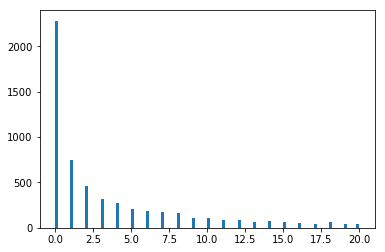

In [28]:
plt.hist(df_eurovoc_count["count"], bins = 100
        , range = [0, 20])

In [29]:
df_eurovoc_count.sort_values(by= "count", ascending = False, inplace = True)

In [30]:
df_eurovoc_count.to_excel("output/df_eurovoc_count.sorted.xlsx",
                          index = False
                         )